# Planejamento da solução (IOT)

## Input - Entrada

### 1. Problema de negócio
    . Selecionar os clientes mais valiosos para integrar um programa o programa de fidelidade "Insiders"
    . Conjunto de dados com vendas de produtos durante 1 ano (nov 2016 à dec 2017)    

## Output - Saída

### 1. A indicação das pessoas que farão parte do programa de fidelização (Insiders)
    . Lista: client_id | is_insider
                 10323 | yes/1
                 32413 | no/1
### 2. Relatório com as respostas das perguntas de negócio
    1. Quem são as pessoas elegíveis para participar do programa de Insiders?
    2. Quantos clientes farão parte do grupo?
    3. Quais as principais caracteristicas desses clientes?
    4. Qual a porcentagem de contribuição do faturameto vinda do Insiders?
    5. Qual a expectativa de faturamento desse grupo para os próximos meses?
    6. Quais as condições para uma pessoa ser elegível ao Insiders?
    7. Quais as condições para uma pessoa ser removida do Insiders?
    8. Qual a garantia que o programa Insiders é melhor que o restante da base?
    9. Quais ações o time de marketing pode realizar para aumentar o faturamento?    

## Task - Tarefas
    1. Quem são as pessoas elegíveis para participar do programa de Insiders?
     - O que é ser elegível?, ou que são clientes de maior 'valor'?
        - Faturamento:
            - Alto ticket médio;
            - Alto LTV (Life time value);
            - Baixa recência (Tempo até o última compra);
            - Alto basket size (Qtde média de produtos comprados);
            - Baixa probabilidade de churn;
            - Alta previsão de LTV;
            - Alta propensão de compra.
        - Custo:
            - Baixo número de devoluções.
        - Experiência de compra:
            - Média alta das avaliações.
             
    2. Quantos clientes farão parte do grupo?
        - Número total de clientes;
        - Percentual do grupo Insiders.
        
    3. Quais as principais caracteristicas desses clientes?
        - Escrever caracteristivas do cliente:
            - Idade;
            - Salário;
            - Pais.
        - Escrever caracteristicas do consumo:
            - Atributos de clusterização (Vide acima).
    
    4. Qual a porcentagem de contribuição do faturameto vinda do Insiders?
        - Faturamento total do ano;
        - Faturamento do grupo Insiders. 
    
    5. Qual a expectativa de faturamento desse grupo para os próximos meses?
        - LTV do grupo Insiders;
        - Análise de Cohort (Análise onde é marcada a pessoa no tempo e avaliado seu comportamento).
    
    6. Quais as condições para uma pessoa ser elegível ao Insiders?
        - Definir a periodicidade (1 mês);
        - A pessoa precisa ser similar ou parecida com uma pessoa do grupo.
    
    7. Quais as condições para uma pessoa ser removida do Insiders?
        - Definir a periodicidade (1 mês);
        - A pessoa precisa ser desimilar ou não-parecida com uma pessoa do grupo.
    
    8. Qual a garantia que o programa Insiders é melhor que o restante da base?
        - Teste A/B;
        - Teste A/B bayesiano;
        - Teste de hipóteses.
    
    9. Quais ações o time de marketing pode realizar para aumentar o faturamento?   
        - Desconto;
        - Preferência de compra;
        - Frete;
        - Visita a empresa.

## Benchmark de soluções
### 1. Pesquisa de mesa

# Bibliotécas

In [1]:
import inflection
import pickle
import s3fs
import os 
import re
import warnings
import umap.umap_                                 as umap
import pandas                                     as pd
import numpy                                      as np
import seaborn                                    as sns
from statsmodels             import api           as sm
from matplotlib              import pyplot        as plt
from sklearn                 import preprocessing as pp
from sklearn                 import mixture       as mx
from sklearn                 import ensemble      as en
from sklearn                 import cluster       as c
from sklearn                 import metrics       as m
from sklearn                 import decomposition as dd
from plotly                  import express       as px
from scipy.cluster           import hierarchy     as hcy
from matplotlib              import cm
from IPython.display         import Image, display
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.manifold        import TSNE
from ydata_profiling         import ProfileReport
from matplotlib.gridspec     import GridSpec
from IPython.display         import HTML
from yellowbrick.cluster     import KElbowVisualizer, SilhouetteVisualizer

warnings.filterwarnings('ignore')

In [2]:
# Variáveis para acessar o S3 da AWS
AWS_ACCESS_KEY_ID = os.environ.get('AWS_ACCESS_KEY_ID')
AWS_SECRET_ACCESS_KEY = os.environ.get('AWS_SECRET_ACCESS_KEY')

# Funções

In [3]:
def jupyter_settings():
    %matplotlib inline

    plt.style.use('ggplot')
    plt.rcParams['figure.figsize'] = [20, 9]
    plt.rcParams['font.size'] = 24

    display(HTML('<style>.container{width: 100% !important;}</style>'))
    
    pd.options.display.max_rows = None
    pd.options.display.max_columns = None
    pd.set_option('display.expand_frame_repr', False)

    sns.set()

    # Aumenta a quantidade de texto mostrado nas células de saída
    from IPython.core.interactiveshell import InteractiveShell
    InteractiveShell.ast_node_interactivity = 'all'
jupyter_settings()

def renomear_colunas(df):
    title = lambda x: inflection.titleize(x)
    snakecase = lambda x: inflection.underscore(x)
    spaces = lambda x: x.replace(" ", "")
    cols_old = list(df.columns)
    cols_old = list(map(title, cols_old))
    cols_old = list(map(spaces, cols_old))
    cols_new = list(map(snakecase, cols_old))
    df.columns = cols_new
    return df

# 1. (Limpeza dos dados) Passo 1: Descrição dos dados

### 1.2 Carregar os dados

In [4]:
ls -la ../dataset

total 41820
drwxr-xr-x  2 leonardo leonardo     4096 Jan 23 21:46 ./
drwxr-xr-x 11 leonardo leonardo     4096 Jan 26 02:22 ../
-rw-r--r--  1 leonardo leonardo 42697197 Apr 29  2021 ecommerce.csv
-rw-r--r--  1 leonardo leonardo   114166 Jan 25 15:13 embedding_tree.csv


In [5]:
path = '/home/leonardo/projetos_/programa_de_fidelidade/dataset' # Caminho absoluto para posteriormente
# utilizar o PaperMill (Executador de jupyter notebook)
df_raw = pd.read_csv(path + '/ecommerce.csv', encoding = 'latin1')
df_raw = df_raw.drop(columns = ['Unnamed: 8'], axis = 1)

df1 = df_raw.copy()

### 1.3 Dimensão dos dados

In [6]:
df1.shape

(541909, 8)

In [7]:
df1.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


### 1.4 Editar as colunas

In [8]:
df1.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [9]:
df1 = renomear_colunas(df1)

In [10]:
df1.columns

Index(['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date',
       'unit_price', 'customer', 'country'],
      dtype='object')

In [11]:
#Corrigindo o nome da coluna 'customer_id' 
df1.columns = ['invoice_no', 'stock_code', 'description', 'quantity', 
               'invoice_date', 'unit_price', 'customer_id', 'country']

### 1.5 Tipo de dados

In [12]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

In [13]:
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


#### 1.5.1 Editar os tipos de dados

In [14]:
# invoice_date
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format = '%d-%b-%y')

In [15]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id            float64
country                 object
dtype: object

### 1.6 Verificar NA's

In [16]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

#### 1.6.1 Tratar NA's

In [17]:
df_missing = df1.loc[df1['customer_id'].isna(), :]
df_not_missing = df1.loc[~df1['customer_id'].isna(), :]

In [18]:
# Para preencher a coluna 'customer_id' faltantes, optou-se em pegar o maior nº do 'customer_id', neste 
# caso 18287 e implementar o novo 'customer_id' a partir do nº 19000, então para cada conjunto 'invoice_no'
df_not_missing['customer_id'].max()

18287.0

In [19]:
# Criando a referência
df_backup = pd.DataFrame(df_missing['invoice_no'].drop_duplicates())
df_backup['customer_id'] = np.arange(19000, 19000 + len(df_backup), 1)

# Juntando o dataframe original com o dataframe de referência
df1 = pd.merge(df1, df_backup, on = 'invoice_no', how = 'left')

# Juntando os dados diferentes de NA das colunas 'customer_id_x' e 'customer_id_y' na coluna 'customer_id' original
df1['customer_id'] = df1['customer_id_x'].combine_first(df1['customer_id_y'])
# combine_first
# Essa função combina os valores de 'customer_id_x' e 'customer_id_y', priorizando 'customer_id_x'
# sempre que estiver disponível e preenchendo com 'customer_id_y' quando 'customer_id_x' é nulo.

# Retirando as colunas 'customer_id_x' e 'customer_id_y'
df1 = df1.drop(columns = ['customer_id_x', 'customer_id_y']) 

df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,United Kingdom,17850.0
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,United Kingdom,17850.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,United Kingdom,17850.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,United Kingdom,17850.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,United Kingdom,17850.0


In [20]:
# No 1º ciclo do CRISP, optou-se removar as linhas com NA's
#df1 = df1.dropna(subset = ['description', 'customer_id'])
#print('Percentual de dados removidos: {:.2f}'.format(1 - (df1.shape[0] / df_raw.shape[0])))
#print('Sobraram: {} linhas'.format(df1.shape[0]))

#### 1.6.2 Verificar NA's novamente

In [21]:
df1.isna().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
country            0
customer_id        0
dtype: int64

### 1.7 Descrição estatística do negócio

#### 1.7.1 Separar as colunas em variáveis numéricas e variáveis categóricas

In [22]:
num_attributes = df1.select_dtypes(include = ['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude = ['int64', 'float64'])

#### 1.7.2 Atributos numéricos

In [23]:
#Métricas de tendência central: média e mediana
central_1 = pd.DataFrame(num_attributes.apply(np.mean)).T
central_2 = pd.DataFrame(num_attributes.apply(np.median)).T

#Métricas de dispersão: desvio padrão, mínimo, máximo, aplitude, assimetrica e curtose
dispersao_1 = pd.DataFrame(num_attributes.apply(np.std)).T
dispersao_2 = pd.DataFrame(num_attributes.apply(np.min)).T
dispersao_3 = pd.DataFrame(num_attributes.apply(np.max)).T
dispersao_4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
dispersao_5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
dispersao_6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

metricas = pd.concat([dispersao_2, dispersao_3, dispersao_4, central_1, central_2, dispersao_1, dispersao_5, dispersao_6]).T
metricas.columns = ['min', 'max', 'amplitude', 'mean', 'median', 'std', 'assimetria', 'kurtosis']
metricas

,min,max,amplitude,mean,median,std,assimetria,kurtosis
quantity,-80995.00,80995.0,161990.00,9.552250,3.00,218.080957,-0.264076,119769.160031
unit_price,-11062.06,38970.0,50032.06,4.611114,2.08,96.759764,186.506972,59005.719097
customer_id,12346.00,22709.0,10363.00,16688.840453,16249.00,2911.408666,0.487449,-0.804287


#### <font color = 'red'> 1.7.2.1 Investigação dos atributos numéricos </font>

In [24]:
# 1. Quantidade negativa, pode ser devolução
# 2. Preço unitário igual a zero?, pode ser promoção

#### 1.7.3 Atributos categóricos

In [25]:
cat_attributes.head()

,invoice_no,stock_code,description,invoice_date,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,2016-11-29,United Kingdom
1,536365,71053,WHITE METAL LANTERN,2016-11-29,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,2016-11-29,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,2016-11-29,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,2016-11-29,United Kingdom


In [26]:
# Encontrando as strings únicas que contém letras

In [27]:
# invoice_no (encontrado invoice com letras e números)
#cat_attributes['invoice_no'] = cat_attributes['invoice_no'].astype(int)
df_letter_invoices = (df1.loc[df1['invoice_no']
                         .apply(lambda x: bool(re.search('[^0-9]+', x))), :])

print('Total de invoices com letras e números: {}'.format(len(df_letter_invoices)))
print('Total de quantidades negativas: {}'.format(len(df_letter_invoices['quantity'] < 0 )))

Total de invoices com letras e números: 9291
Total de quantidades negativas: 9291


In [28]:
# stock_code
len(df1.loc[df1['stock_code'].apply(lambda x: bool(re.search('[^0-9]+', x))), 'stock_code'].drop_duplicates())

1124

In [29]:
# stock_code
# Identificando as strings com somente letras
df1.loc[df1['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x))), 'stock_code'].unique()
# Remover os itens ['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK'], pois parece ser sujeira nos dados

array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

In [30]:
# customer_id
# Remover o customer_id = 16446.0 pois é um outlier e não tem sentido com o problema estudado
df1 = df1[~df1['customer_id'].isin([16446.0])]

In [31]:
# description
df1.head()
# Remover essa coluna, pois não tem muita relação com o fenômeno estudado

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,United Kingdom,17850.0
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,United Kingdom,17850.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,United Kingdom,17850.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,United Kingdom,17850.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,United Kingdom,17850.0


In [32]:
# country
df1['country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

In [33]:
df1['country'].value_counts(normalize = True).head()

country
United Kingdom    0.914319
Germany           0.017522
France            0.015791
EIRE              0.015124
Spain             0.004674
Name: proportion, dtype: float64

In [34]:
df1['country'].nunique()

38

# 2. (Limpeza dos dados) Passo 2: Filtragem de variáveis (restrição do negócio)

In [35]:
df2 = df1.copy()

### 2.1 Atributos numéricos

In [36]:
# unit_price > 0.04
df2 = df2.loc[df2['unit_price'] > 0.04, :]

### 2.2 Atributos categóricos

In [37]:
# stock_code > 0.0
df2 = df2[~df2['stock_code'].isin(['POST', 'D', 'DOT', 'M',
                                   'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
                                   'DCGSSGIRL', 'PADS', 'B', 'CRUK'])]

# description
df2 = df2.drop(columns = 'description', axis = 1)

# country
df2 = df2[~df2['country'].isin(['European Community', 'Unspecified'])]

In [38]:
df2['country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Brazil', 'USA', 'Malta', 'RSA'],
      dtype=object)

In [39]:
# quantity - Separando as quantidades positivas e negativas
df2_returns = df2.loc[df2['quantity'] < 0, :]
df2_purchase = df2.loc[df2['quantity'] >= 0, :]

# 3. (Limpeza dos dados) Passo 3: Engenharia de variáveis

In [40]:
df3 = df2.copy()

### 3.1 Derivando as variáveis a partir das variáveis originais

#### 3.1.1 Criação da coluna de referência

In [41]:
# Baseando-se nas variáveis RFM (Recência, frequência, monetização) criar as variáveis a partir da coluna 'customer_id'
# com valores únicos para assim reduzir a granularidade dos dados

In [42]:
# Criando uma tabela de referência
df_ref = df3.drop(['invoice_no', 'stock_code', 'quantity',
                   'invoice_date', 'unit_price', 'country'], axis = 1).drop_duplicates(ignore_index = True)
df_ref.head()

,customer_id
0,17850.0
1,13047.0
2,12583.0
3,13748.0
4,15100.0


#### 3.1.2 Criação da coluna Monetary

In [43]:
# Com o dataframe de referência criado 'customer_id', todas
# as colunas que serão criadas serão adicionadas a esta coluna

In [44]:
# Faturamento (qtde * preço), também chamada como Gross_Revenue
df2_purchase.loc[:, 'gross_revenue'] = df2_purchase.loc[:, 'quantity'] * df2_purchase.loc[:, 'unit_price']

# Monetary
df_monetary = df2_purchase[['customer_id','gross_revenue']].groupby('customer_id').sum().reset_index()

# Juntando os colunas criadas a coluna de referência
df_ref = pd.merge(df_ref, df_monetary, on = 'customer_id', how = 'left')

# Após fazer qualquer junção de dataframes, verificar se existem NA's,
# pois é uma maneira de verificar se deu certo a junção
df_ref.isna().sum()

customer_id       0
gross_revenue    91
dtype: int64

#### 3.1.2 Criação da coluna Recency

In [45]:
# Recência (qtde dias até a última compra do cliente, ou seja, maior data do dataset - data última compra)
df_recency = df2_purchase.loc[:, ['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df2_purchase['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()

# Juntando os colunas criadas a coluna de referência
df_ref = pd.merge(df_ref, df_recency, on = 'customer_id', how = 'left')

# Após fazer qualquer junção de dataframes, verificar se existem NA's,
# pois é uma maneira de verificar se deu certo a junção
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
dtype: int64

#### 3.1.3 Criação da coluna Quantidade de compras <font color = 'red'>(Task definidas no começo do projeto)</font>

In [46]:
# Quantidade de compras por cliente
df_qtde_cliente = (df2_purchase.loc[:, ['customer_id', 'invoice_no']].drop_duplicates()
                                                                     .groupby('customer_id')
                                                                     .count()
                                                                     .reset_index()
                                                                     .rename(columns = {'invoice_no': 'qty_invoices'}))

# Juntando os colunas criadas a coluna de referência
df_ref = pd.merge(df_ref, df_qtde_cliente, on = 'customer_id', how = 'left')

# Após fazer qualquer junção de dataframes, verificar se existem NA's,
# pois é uma maneira de verificar se deu certo a junção
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qty_invoices     91
dtype: int64

#### 3.1.4 Criação da coluna Quantidade de itens comprados <font color = 'red'>(Task definidas no começo do projeto)</font>

In [47]:
# Quantidade de itens comprados
df_qtde = (df2_purchase.loc[:, ['customer_id', 'quantity']].groupby('customer_id')
                                                           .sum()
                                                           .reset_index()
                                                           .rename(columns = {'quantity': 'qty_itens'}))

# Juntando os colunas criadas a coluna de referência
df_ref = pd.merge(df_ref, df_qtde, on = 'customer_id', how = 'left')

# Após fazer qualquer junção de dataframes, verificar se existem NA's,
# pois é uma maneira de verificar se deu certo a junção
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qty_invoices     91
qty_itens        91
dtype: int64

#### 3.1.5 Criação da coluna Quantidade de produtos comprados <font color = 'red'>(Task definidas no começo do projeto)</font>

In [48]:
# Quantidade de produtos comprados
df_qtde = (df2_purchase.loc[:, ['customer_id', 'stock_code']].groupby('customer_id')
                                                             .count()
                                                             .reset_index()
                                                             .rename(columns = {'stock_code': 'qty_products'}))

# Juntando os colunas criadas a coluna de referência
df_ref = pd.merge(df_ref, df_qtde, on = 'customer_id', how = 'left')

# Após fazer qualquer junção de dataframes, verificar se existem NA's,
# pois é uma maneira de verificar se deu certo a junção
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qty_invoices     91
qty_itens        91
qty_products     91
dtype: int64

#### 3.1.6 Criação da coluna Avg Ticket

In [49]:
# Ticket médio
df_avg_ticket = (df2_purchase.loc[:, ['customer_id','gross_revenue']].groupby('customer_id')
                                                                     .mean()
                                                                     .reset_index()
                                                                     .rename(columns = {'gross_revenue': 'avg_ticket'}))

# Juntando os colunas criadas a coluna de referência
df_avg_ticket['avg_ticket'] = np.round(df_avg_ticket['avg_ticket'], 2)
df_ref = pd.merge(df_ref, df_avg_ticket, on = 'customer_id', how = 'left')

# Após fazer qualquer junção de dataframes, verificar se existem NA's,
# pois é uma maneira de verificar se deu certo a junção
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qty_invoices     91
qty_itens        91
qty_products     91
avg_ticket       91
dtype: int64

#### 3.1.7 Criação da coluna Média de dias de recência <font color = 'red'>(Task definidas no começo do projeto)</font>

In [50]:
# Média de dias de recência
df_aux = df2[['customer_id', 'invoice_date']].drop_duplicates().sort_values(['customer_id', 'invoice_date'], ascending = [True, True])

# Deslocando as colunas 'customer_id' e 'invoice_date' uma linha para frente, ou seja, deslocando no tempo
df_aux['previous_customer_id'] = df_aux['customer_id'].shift()
df_aux['previous_invoice_date'] = df_aux['invoice_date'].shift()

# Subtrair as linhas que o 'customer_id' são iguais
df_aux['avg_recency_days'] = (df_aux.apply(lambda x: (x['invoice_date'] - x['previous_invoice_date'])
                                    .days if x['customer_id'] == x['previous_customer_id'] else np.nan, axis = 1))
df_aux = df_aux.drop(['invoice_date', 'previous_customer_id', 'previous_invoice_date'], axis = 1).dropna()
df_avg_recency_days = df_aux.groupby('customer_id').mean().reset_index()

# Juntando os colunas criadas a coluna de referência
df_ref = pd.merge(df_ref, df_avg_recency_days, on = 'customer_id', how = 'left')

# Após fazer qualquer junção de dataframes, verificar se existem NA's,
# pois é uma maneira de verificar se deu certo a junção
df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qty_invoices          91
qty_itens             91
qty_products          91
avg_ticket            91
avg_recency_days    2816
dtype: int64

#### 3.1.8 Criação da coluna Frequency

In [51]:
# Frequência
df_freq = (df2_purchase[['customer_id', 'invoice_no', 'invoice_date']].drop_duplicates()
                                                                      .groupby('customer_id')
                                                                      .agg(max_ = ('invoice_date', 'max'),
                                                                           min_ = ('invoice_date', 'min'),
                                                                           days_ = ('invoice_date', lambda x: ((x.max() - x.min()).days) + 1),
                                                                           buy_ = ('invoice_no', 'count')).reset_index())

df_freq['frequency'] = df_freq[['buy_', 'days_']].apply(lambda x: x['buy_'] / x['days_'] if x['days_'] != 0 else 0, axis = 1)

# Juntando os colunas criadas a coluna de referência
df_ref = pd.merge(df_ref, df_freq[['customer_id', 'frequency']], on = 'customer_id', how = 'left')

# Após fazer qualquer junção de dataframes, verificar se existem NA's,
# pois é uma maneira de verificar se deu certo a junção
df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qty_invoices          91
qty_itens             91
qty_products          91
avg_ticket            91
avg_recency_days    2816
frequency             91
dtype: int64

#### 3.2.0 Criação da coluna Número de returns <font color = 'red'>(Task definidas no começo do projeto)</font>

In [52]:
# Número de returns
df_returns = (df2_returns[['customer_id','quantity']].groupby('customer_id')
                                                     .sum()
                                                     .reset_index()
                                                     .rename(columns = {'quantity': 'qty_returns'}))

# Convertendo para positivo
df_returns['qty_returns'] = df_returns['qty_returns'] * -1

# Juntando os colunas criadas a coluna de referência
df_ref = pd.merge(df_ref, df_returns, on = 'customer_id', how = 'left')

# Se encontrar linhas com NA's substituir por 0
df_ref.loc[df_ref['qty_returns'].isna(), 'qty_returns'] = 0

# Após fazer qualquer junção de dataframes, verificar se existem NA's,
# pois é uma maneira de verificar se deu certo a junção
df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qty_invoices          91
qty_itens             91
qty_products          91
avg_ticket            91
avg_recency_days    2816
frequency             91
qty_returns            0
dtype: int64

#### 3.2.1 Criação da coluna Basket size <font color = 'red'>(Task definidas no começo do projeto)</font>

In [53]:
# Basket size (Quantidade de produtos por cesta)
df_aux = (df2_purchase.loc[:, ['customer_id', 'invoice_no', 'quantity']].groupby('customer_id')
                                                                        .agg(n_purchase = ('invoice_no', 'nunique'),
                                                                             n_products = ('quantity', 'sum')).reset_index())

# Calculando o tamanho do basket size
df_aux['avg_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

# Juntando os colunas criadas a coluna de referência
df_ref = pd.merge(df_ref, df_aux[['customer_id', 'avg_basket_size']], on = 'customer_id', how = 'left')

# Após fazer qualquer junção de dataframes, verificar se existem NA's,
# pois é uma maneira de verificar se deu certo a junção
df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qty_invoices          91
qty_itens             91
qty_products          91
avg_ticket            91
avg_recency_days    2816
frequency             91
qty_returns            0
avg_basket_size       91
dtype: int64

#### 3.2.2 Criação da coluna Basket size únicos <font color = 'red'>(Task definidas no começo do projeto)</font>

In [54]:
# Unique basket size (Quantidade de produtos distintos por compra)
df_aux = (df2_purchase.loc[:, ['customer_id', 'invoice_no', 'stock_code']].groupby('customer_id')
                                                                          .agg(n_purchase = ('invoice_no', 'nunique'),
                                                                               n_products = ('stock_code', 'nunique')).reset_index())

# Calculando a média do basket size
df_aux['avg_unique_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

# Juntando os colunas criadas a coluna de referência
df_ref = pd.merge(df_ref, df_aux[['customer_id', 'avg_unique_basket_size']], on = 'customer_id', how = 'left')

# Após fazer qualquer junção de dataframes, verificar se existem NA's,
# pois é uma maneira de verificar se deu certo a junção
df_ref.isna().sum()

customer_id                  0
gross_revenue               91
recency_days                91
qty_invoices                91
qty_itens                   91
qty_products                91
avg_ticket                  91
avg_recency_days          2816
frequency                   91
qty_returns                  0
avg_basket_size             91
avg_unique_basket_size      91
dtype: int64

# 4. (Exploração dos dados) Passo 4: Análise exploratória dos dados (Negócio)

In [55]:
df4 = df_ref.dropna().copy()

In [56]:
df4.isna().sum()

customer_id               0
gross_revenue             0
recency_days              0
qty_invoices              0
qty_itens                 0
qty_products              0
avg_ticket                0
avg_recency_days          0
frequency                 0
qty_returns               0
avg_basket_size           0
avg_unique_basket_size    0
dtype: int64

### 4.1 Análise univariada

In [57]:
# ALGUMAS ANOTAÇÕES IMPORTANTES:

# 1. Em problemas de clusterização, estamos buscando clusters coesos (compactos) e separados dos outros clusters;

# 2. Para definir uma variável relevante, observa-se sua variabilidade, ou seja, se a variável varia muito em seu eixo,
# por exemplo, se seu minimo e máximo ou amplitude é muito grande, significa que aquele eixo no espaço original tem 
# uma variabilidade maior, então quando combino com qualquer outra variável, a chance de formar cluster é muito maior.
# Em resumo, atentar para as métricas:
# -> Mín, máx, amplitude (dispersão)
# -> Média e mediana, se estas métricas forem iguais ou próximas, não teriamos
# variabilidade, então buscamos que elas sejam mais afastadas entre si
# -> Coeficiente de variação (desvio_padrão / média), buscar variáveis com CV mais alto

# Outras anotações:
# Na análise univariada, busca-se avaliar se os valores extremos são naturais, ou seja, fazem parte do comportamento
# dos dados, ou se é algum problemaque foi imputado?, neste último caso, investigar estes valores 

In [58]:
profile = ProfileReport(df4)
profile.to_file('output.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

#### 4.1.1 Gross revenue

In [59]:
# Esta variável apresentou valores extremos no arquivo do ProfileReport, avaliar se fazem sentido estes valores
#95-th percentile	7219.68
#Maximum	279138.02
#Coefficient of variation (CV)	3.8485342
df4[df4['customer_id'] == 14646]

# INVESTIGAR / REMOVER -> gross_revenue - Ok

,customer_id,gross_revenue,recency_days,qty_invoices,qty_itens,qty_products,avg_ticket,avg_recency_days,frequency,qty_returns,avg_basket_size,avg_unique_basket_size
1017,14646.0,279138.02,1.0,72.0,196844.0,2060.0,135.5,7.844444,0.20339,288.0,2733.944444,9.708333


#### 4.1.2 Quantidade de produtos

In [60]:
# Esta variável apresentou valores extremos no arquivo do ProfileReport, avaliar se fazem sentido estes valores
#95-th percentile	382
#Maximum	7837
#Coefficient of variation (CV)	2.1991065
df4[df4['qty_products'] == 7837]

# INVESTIGAR / REMOVER -> qty_products - Ok

,customer_id,gross_revenue,recency_days,qty_invoices,qty_itens,qty_products,avg_ticket,avg_recency_days,frequency,qty_returns,avg_basket_size,avg_unique_basket_size
68,17841.0,40959.72,1.0,124.0,22853.0,7837.0,5.23,3.321429,0.33244,203.0,184.298387,10.653226


#### 4.1.3 Ticket médio

In [61]:
# Esta variável apresentou valores extremos no arquivo do ProfileReport, avaliar se fazem sentido estes valores
#95-th percentile	90.498
#Maximum	56157.5
#Coefficient of variation (CV)	19.97947
df4[df4['avg_ticket'] == 56157.5]

# INVESTIGAR / REMOVER -> avg_ticket - Remover

,customer_id,gross_revenue,recency_days,qty_invoices,qty_itens,qty_products,avg_ticket,avg_recency_days,frequency,qty_returns,avg_basket_size,avg_unique_basket_size


In [62]:
df3[df3['customer_id'] == 16446.0]

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id


#### 4.1.4 Qtde de itens

In [63]:
# Esta variável apresentou valores extremos no arquivo do ProfileReport, avaliar se fazem sentido estes valores
#95-th percentile	4407.4
#Maximum	196844
#Coefficient of variation (CV)	3.6620722
df4[df4['qty_itens'] == 196844]

# INVESTIGAR / REMOVER -> qty_itens - Ok

,customer_id,gross_revenue,recency_days,qty_invoices,qty_itens,qty_products,avg_ticket,avg_recency_days,frequency,qty_returns,avg_basket_size,avg_unique_basket_size
1017,14646.0,279138.02,1.0,72.0,196844.0,2060.0,135.5,7.844444,0.20339,288.0,2733.944444,9.708333


In [64]:
df3[df3['customer_id'] == 14646.0].head()

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id
37952,539491,21981,12,2016-12-18,0.29,Netherlands,14646.0
37953,539491,21986,12,2016-12-18,0.29,Netherlands,14646.0
37954,539491,22720,2,2016-12-18,4.95,Netherlands,14646.0
37955,539491,21931,1,2016-12-18,1.95,Netherlands,14646.0
37956,539491,22613,2,2016-12-18,0.85,Netherlands,14646.0


#### 4.1.5 Frequência

In [65]:
# Esta variável apresentou valores extremos no arquivo do ProfileReport, avaliar se fazem sentido estes valores
#95-th percentile	1
#Maximum	17
#Coefficient of variation (CV)	3.5868949
df4[df4['frequency'] == 17]

# INVESTIGAR / REMOVER -> frequency - Ok

,customer_id,gross_revenue,recency_days,qty_invoices,qty_itens,qty_products,avg_ticket,avg_recency_days,frequency,qty_returns,avg_basket_size,avg_unique_basket_size
0,17850.0,5391.21,372.0,34.0,1733.0,297.0,18.15,35.5,17.0,40.0,50.970588,0.617647


In [66]:
df3[df3['customer_id'] == 17850.0].head()

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,6,2016-11-29,2.55,United Kingdom,17850.0
1,536365,71053,6,2016-11-29,3.39,United Kingdom,17850.0
2,536365,84406B,8,2016-11-29,2.75,United Kingdom,17850.0
3,536365,84029G,6,2016-11-29,3.39,United Kingdom,17850.0
4,536365,84029E,6,2016-11-29,3.39,United Kingdom,17850.0


### 4.2 Análise bivariada

In [67]:
# Algumas anotações importantes:
# 1. Na análise bivariada, estamos buscando identificar quais variáveis
# combinadas 2 a 2 teriam algum tipo de variabilidade entre elas

In [68]:
df4.columns

Index(['customer_id', 'gross_revenue', 'recency_days', 'qty_invoices',
       'qty_itens', 'qty_products', 'avg_ticket', 'avg_recency_days',
       'frequency', 'qty_returns', 'avg_basket_size',
       'avg_unique_basket_size'],
      dtype='object')

In [69]:
# Variáveis que possuem pouca variação e com isso candidatas a serem removidas,
# por exemplo, olhar nos eixos e verificar se os dados estão concentrados ou 
# distribuidos, se estiverem concentrados, significa que não tem muita variação:
# 1. frequency
# 1. avg_ticket

<Figure size 2000x500 with 0 Axes>

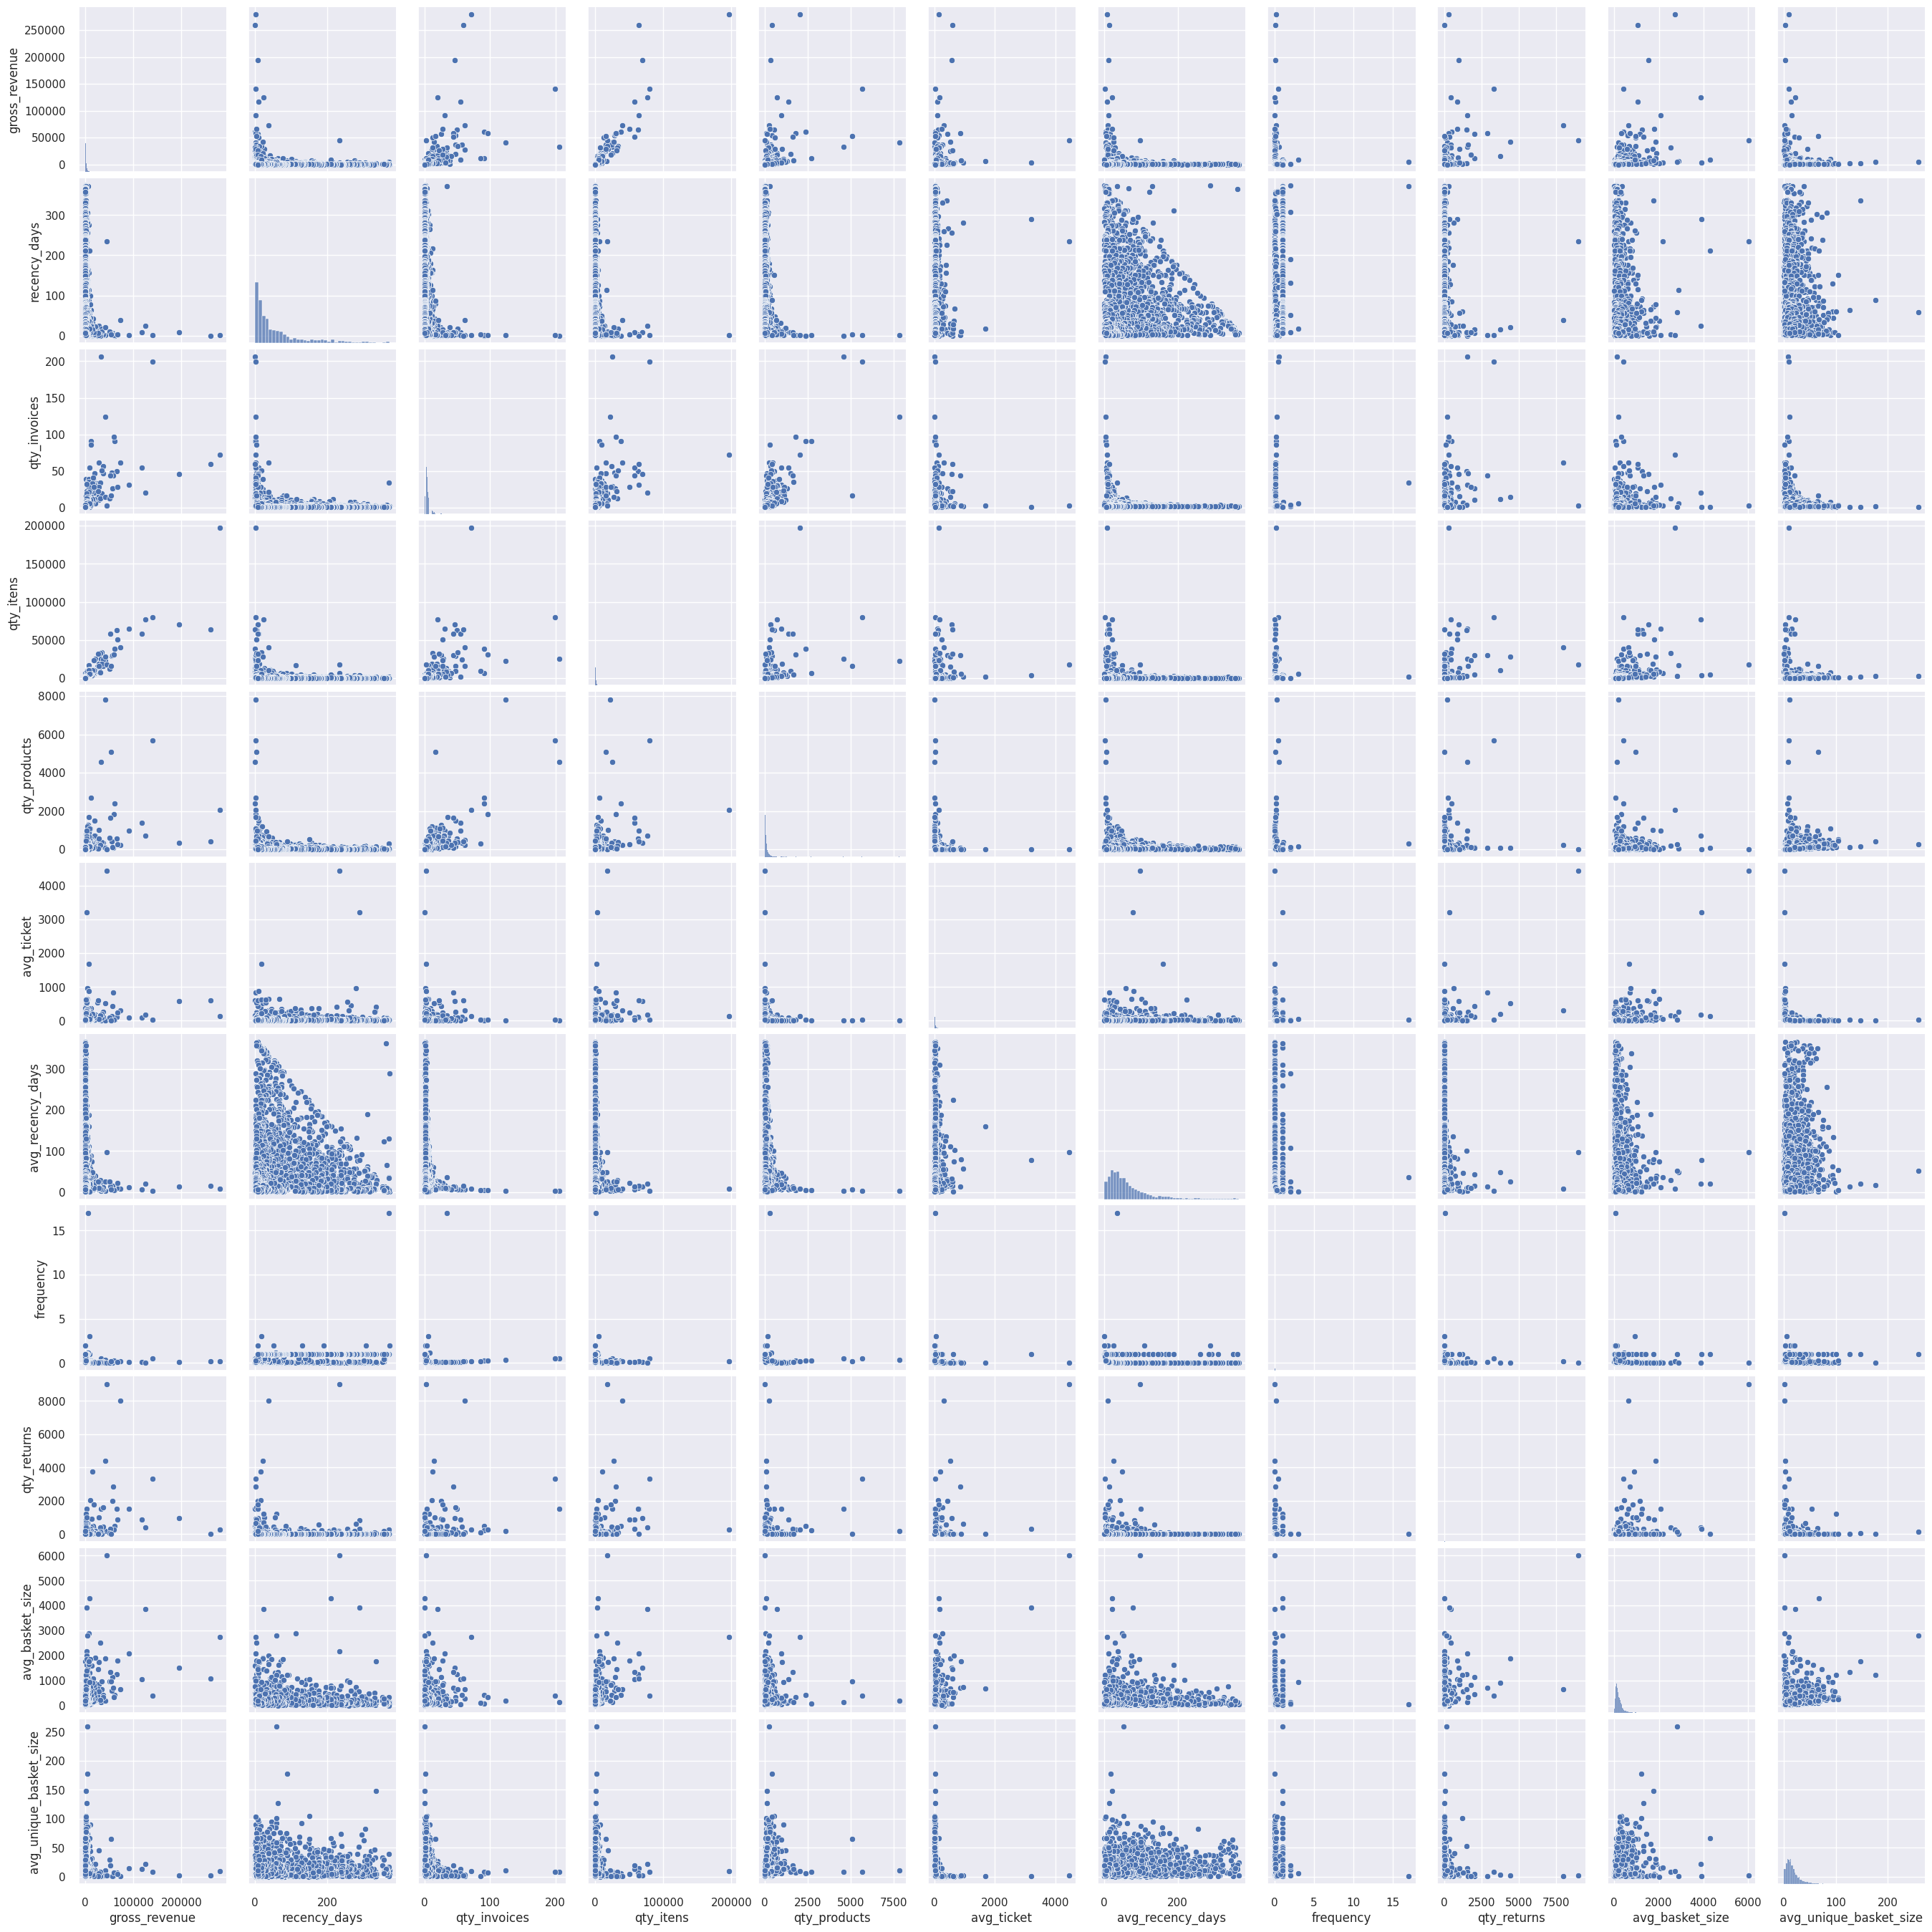

In [70]:
plt.figure(figsize = (20, 5))

df42 = df4.drop(columns = 'customer_id', axis = 1);
sns.pairplot(df42);

### 4.3 Estudo do espaço (Algoritmos de Embedding)

In [71]:
# O termo "embedding" refere-se a uma técnica utilizada para representar dados de alta dimensionalidade em 
# um espaço de menor dimensão. Em resumo, embeddings são representações numéricas de dados complexos em um
# espaço de menor dimensão, facilitando o manuseio e a interpretação por modelos de aprendizado de máquina

# Uma desvantagem de utilizar embedding, em alguns casos, embeddings podem ser difíceis de
# interpretar, especialmente em espaços de alta dimensionalidade. Entender o significado 
# específico de cada dimensão e também a explicabilidade do espaço de embedding pode ser um desafio,
# por exemplo, o porque o cliente A é vizinho do cliente B nos dados originais?
# No espaço gerado pelo embedding, é mais facil enteder isso, mas no espaço original não

In [72]:
# Para fazer o estudo do espaço embedding, os dados precisam estar transformados

In [73]:
#df43 = df4.drop(columns = 'customer_id', axis = 1).copy()
cols_selected = ['customer_id', 'gross_revenue', 'recency_days', 'qty_products', 'frequency', 'qty_returns']
df43 = df4[cols_selected].drop(columns = 'customer_id', axis = 1)

In [74]:
df43.columns

Index(['gross_revenue', 'recency_days', 'qty_products', 'frequency',
       'qty_returns'],
      dtype='object')

In [75]:
mm = pp.MinMaxScaler()
fs = s3fs.S3FileSystem(anon = False, key = AWS_ACCESS_KEY_ID, secret = AWS_SECRET_ACCESS_KEY)

df43['gross_revenue'] = mm.fit_transform(df43[['gross_revenue']])
# Salvando na máquina local
pickle.dump(mm, open('../transformacoes/gross_revenue_scaler.pkl', 'wb')) # Salvando as transformações em arquivo pickle
# Salvando na nuvem (S3 na AWS)
pickle.dump(mm, fs.open('s3://cluster-insiders-dataset/gross_revenue_scaler.pkl', 'wb')) # Salvando as transformações em arquivo pickle

df43['recency_days'] = mm.fit_transform(df43[['recency_days']])
# Salvando na máquina local
pickle.dump(mm, open('../transformacoes/recency_days_scaler.pkl', 'wb')) # Salvando as transformações em arquivo pickle
# Salvando na nuvem (S3 na AWS)
pickle.dump(mm, fs.open('s3://cluster-insiders-dataset/recency_days_scaler.pkl', 'wb')) # Salvando as transformações em arquivo pickle

df43['qty_products'] = mm.fit_transform(df43[['qty_products']])
# Salvando na máquina local
pickle.dump(mm, open('../transformacoes/qty_products_scaler.pkl', 'wb')) # Salvando as transformações em arquivo pickle
# Salvando na nuvem (S3 na AWS)
pickle.dump(mm, fs.open('s3://cluster-insiders-dataset/qty_products_scaler.pkl', 'wb')) # Salvando as transformações em arquivo pickle

df43['frequency'] = mm.fit_transform(df43[['frequency']])
# Salvando na máquina local
pickle.dump(mm, open('../transformacoes/frequency_scaler.pkl', 'wb')) # Salvando as transformações em arquivo pickle
# Salvando na nuvem (S3 na AWS)
pickle.dump(mm, fs.open('s3://cluster-insiders-dataset/frequency_scaler.pkl', 'wb')) # Salvando as transformações em arquivo pickle

df43['qty_returns'] = mm.fit_transform(df43[['qty_returns']])
# Salvando na máquina local
pickle.dump(mm, open('../transformacoes/qty_returns_scaler.pkl', 'wb')) # Salvando as transformações em arquivo pickle
# Salvando na nuvem (S3 na AWS)
pickle.dump(mm, fs.open('s3://cluster-insiders-dataset/qty_returns_scaler.pkl', 'wb')) # Salvando as transformações em arquivo pickle

x = df43.copy()

In [76]:
df43.head()

,gross_revenue,recency_days,qty_products,frequency,qty_returns
0,0.019292,0.997319,0.037774,1.000000,0.004438
1,0.011559,0.150134,0.021695,0.001345,0.003883
2,0.024000,0.005362,0.029479,0.002052,0.005547
3,0.003375,0.254692,0.003446,0.000734,0.000000
4,0.003116,0.892761,0.000255,0.003985,0.002441


#### 4.3.1 PCA (Análise de Componentes Principais)

In [77]:
x.shape

(2968, 5)

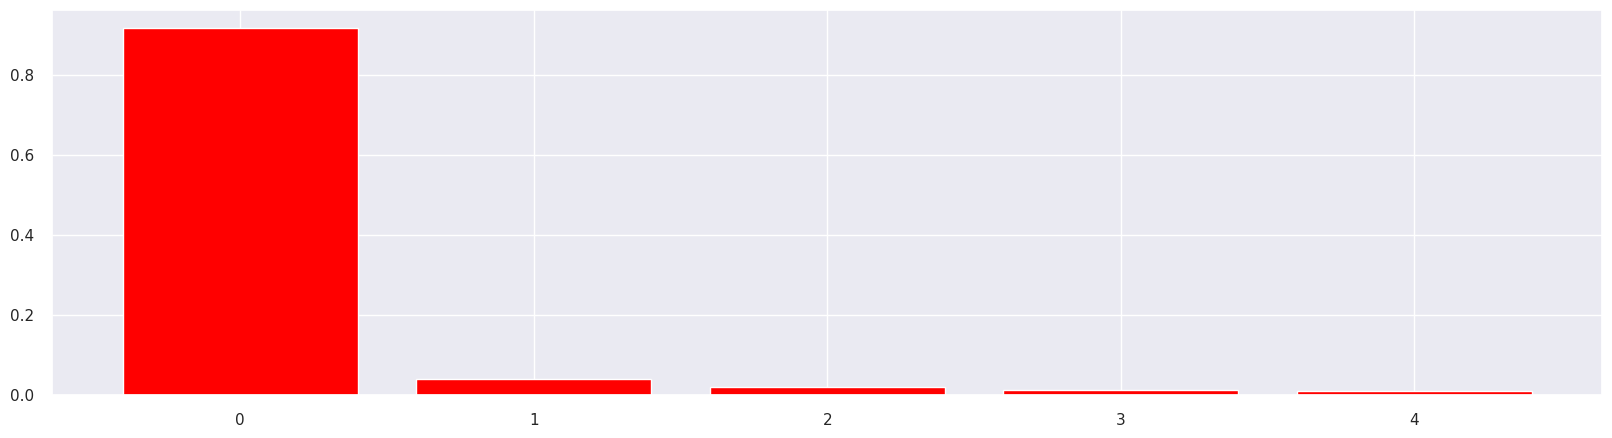

In [78]:
plt.figure(figsize = (20, 5))

pca = dd.PCA(n_components = x.shape[1]) # Qtde de colunas no dataframe

principal_components = pca.fit_transform(x)

# Plotando a variância dos componentes principais
variaveis = range(pca.n_components_) # Criando o eixo x

plt.bar(variaveis, pca.explained_variance_ratio_, color = 'red') # Criando o eixo y

# Criando um dataframe com as variáveis do PCA
df_pca = pd.DataFrame(principal_components);

In [79]:
# Pegar as barras com maior variação, neste caso, as variáveis 0 e 1 

In [80]:
df_pca.head()

,0,1,2,3,4
0,0.856575,0.078326,-0.053370,-0.045908,0.961006
1,-0.022658,0.003950,-0.003358,-0.001541,-0.004552
2,-0.167734,0.013178,-0.003732,0.002341,0.000940
3,0.082506,-0.010301,0.003273,0.003947,-0.007884
4,0.719949,0.009960,-0.003398,0.003325,-0.027119


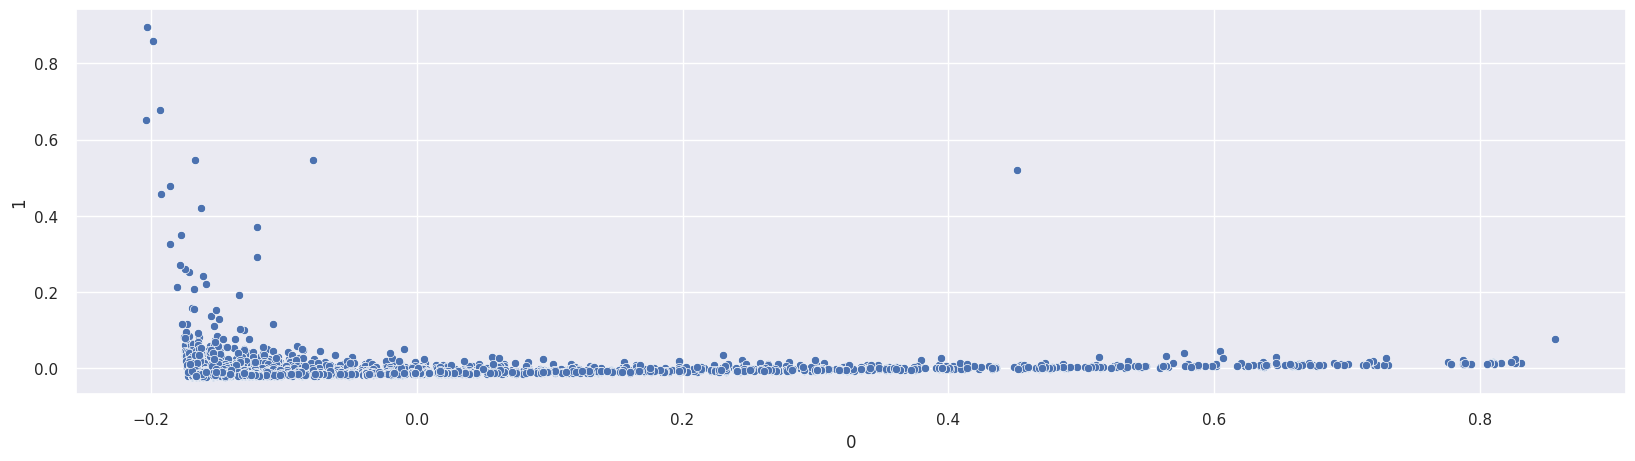

In [81]:
plt.figure(figsize = (20, 5))

sns.scatterplot(x = 0, y = 1, data = df_pca);

#### 4.3.2 UMAP (Uniform Manifold Approximation and Projection)

In [82]:
# Quando instalar a bibliotéca do umap, utilizar umap-learn, conforme mostrado abaixo
#pip install umap-learn

# UMAP é menos preciso e indicado para muitos dados devido sua maior simplicidade matemática

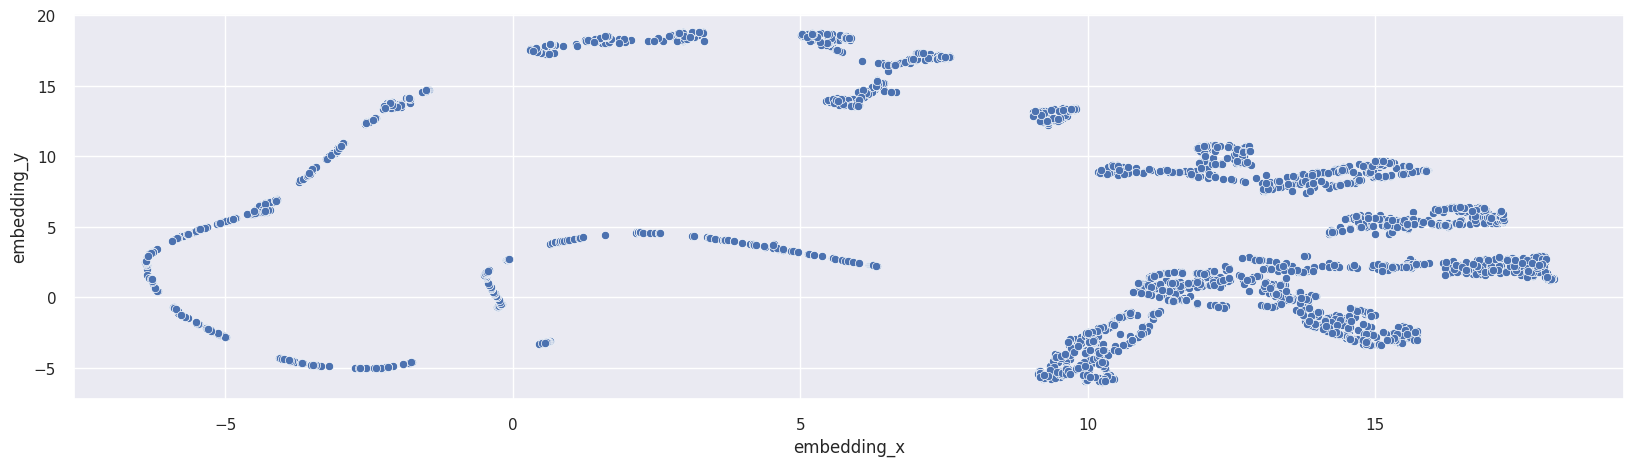

In [83]:
plt.figure(figsize = (20, 5))

reducer = umap.UMAP(random_state = 42)
embedding = reducer.fit_transform(x)

#Embedding
df_umap = pd.DataFrame()
df_umap['embedding_x'] = embedding[:, 0]
df_umap['embedding_y'] = embedding[:, 1]

# Plotando o UMAP
sns.scatterplot(x = 'embedding_x', y = 'embedding_y', data = df_umap);

In [84]:
# O que analisar neste gráfico?, se os pontos com as mesmas cores estiverem próximos uns dos outros,
# significa que na alta dimensionalidade a probabilidade dos os pontos estarem no mesmo cluster é alta

#### 4.3.3 t-SNE (t-Distributed Stochastic Neighbor Embedding)

In [85]:
# t-SNE é mais preciso e indicado para poucos dados devido sua complexidade matemática

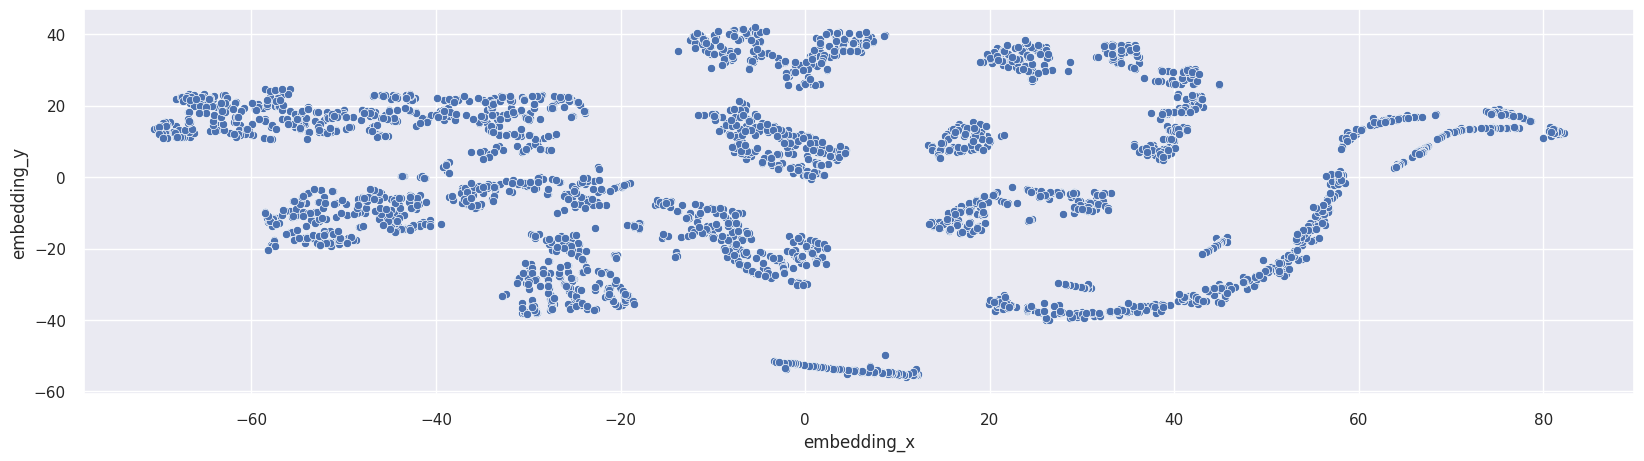

In [86]:
plt.figure(figsize = (20, 5))

reducer = TSNE(n_components = 2, random_state = 42) # n_components = 2 significa reduzir para 2d
embedding = reducer.fit_transform(x)

#Embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

# Plotando o t_SNE
sns.scatterplot(x = 'embedding_x', y = 'embedding_y', data = df_pca);

#### 4.3.4 Árvores

In [87]:
# Para utlizar as árvores, é preciso encontrar uma variável resposta ou uma variável de interesse para
# este problema, ou seja, transformar um problema não supervisionado para um supervisionado e pensando 
# no negócio, preciso encontrar uma variável onde eu teria uma maior separação entre os clusters, neste
# caso utilizaremos a variável 'gross_revenue', pois refere-se ao faturamento, e o problema precisa 
# definir um grupo de pessoas mais relevantes para empresa e como relevância busca-se as pessoas que 
# gastam mais, a variável referente a faturamento seria a mais indicada para o problema em questão

In [88]:
# Como esta sendo utilizado uma árvore, os dados não precisam estar transformados

In [89]:
df43.head()

,gross_revenue,recency_days,qty_products,frequency,qty_returns
0,0.019292,0.997319,0.037774,1.000000,0.004438
1,0.011559,0.150134,0.021695,0.001345,0.003883
2,0.024000,0.005362,0.029479,0.002052,0.005547
3,0.003375,0.254692,0.003446,0.000734,0.000000
4,0.003116,0.892761,0.000255,0.003985,0.002441


In [90]:
# Separando as variáveis em resposta e preditoras
x = df43.drop(columns = 'gross_revenue', axis = 1)
y = df43['gross_revenue']

# Definição do modelo
rf_modelo = en.RandomForestRegressor(n_estimators = 100, random_state = 42)

# Treinando o modelo
rf_modelo.fit(x, y)

# Salvando na máquina local
#pickle.dump(rf_modelo, open('../modelo/rf_modelo.pkl', 'wb'))
# Salvando na nuvem (S3 na AWS)
pickle.dump(rf_modelo, fs.open('s3://cluster-insiders-dataset/rf_modelo.pkl', 'wb')) # Salvando as transformações em arquivo pickle

# Folhas
df_folhas = pd.DataFrame(rf_modelo.apply(x))

RandomForestRegressor(random_state=42)

In [91]:
ls -l.

ls: invalid option -- '.'
Try 'ls --help' for more information.


In [92]:
df_folhas.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,3466,3439,3726,3677,3655,3752,3611,3688,3684,3490,3668,3543,3545,3578,3553,3490,3316,3420,3407,3244,3527,3653,3637,3582,3500,3425,3283,3394,3394,3762,3305,3603,3336,3458,3561,3391,3487,3654,3458,3617,3502,3624,3646,3676,3413,3437,3500,3741,3593,3378,3567,3545,3517,3392,3744,3697,3394,3656,3437,3696,3484,3482,3534,3759,3641,3490,3496,3563,3513,3520,3708,3734,3642,3704,3711,3513,3647,3562,3649,3410,3577,3546,3505,3670,3467,3629,3666,3687,3624,3411,3450,3392,3421,3679,3588,3704,3667,3406,3622,3653
1,3334,3394,3600,3055,3024,3386,3150,3515,3314,3244,3048,3445,3306,3396,3497,3407,3289,3277,3323,3173,3360,3524,2894,2898,3370,3219,3274,3304,3254,3155,3244,3424,3316,3311,3316,3371,3372,3140,3058,3057,3361,3170,3065,3126,3381,3411,3298,3262,3338,3253,3145,3423,3509,2992,3511,3103,3333,3650,3202,3231,3359,3301,2964,3147,3452,3210,3068,2860,3412,3255,3180,3106,3163,2701,3290,3124,3227,3429,3367,3389,3282,3268,3370,3534,3340,3069,3276,3153,3045,3385,2810,3271,3056,2967,3407,2983,2976,3308,3023,3509
2,3517,2982,3627,3580,3555,3666,3282,3551,3329,3330,3613,3473,3422,3517,3470,3471,3021,3360,3447,3236,3476,3518,3268,3246,3401,3381,3030,3350,3206,3659,3248,3414,3297,3495,3512,3467,3534,3580,3482,3536,3556,3224,3553,3562,3316,3423,3355,3239,3540,3380,3558,3500,3452,3467,3566,3645,3486,3534,3210,3311,3491,3440,3522,3638,3492,3442,3247,3560,3456,3001,3642,3646,3655,3621,3051,3509,3273,3505,3397,3075,3261,3221,3399,3558,3406,3560,3291,3713,3331,3434,3420,3341,3477,3531,3527,3590,3042,3381,3537,3584
3,1127,543,1214,307,854,346,537,933,1296,1146,814,361,569,465,1075,820,927,720,379,1104,564,393,1254,426,466,587,1233,646,1161,326,621,544,1212,985,1159,1041,1426,397,399,1281,591,1262,1031,540,1138,1022,588,469,722,971,407,386,1115,601,1504,1154,313,531,785,364,649,970,996,1268,1131,315,497,869,323,1107,671,1254,360,1471,1257,665,607,1209,1236,387,1164,1135,1042,1158,374,971,978,957,750,1130,538,1545,576,600,1057,1308,568,523,924,890
4,436,631,377,889,911,778,1022,36,562,485,143,511,50,714,528,460,544,1104,719,574,688,91,135,712,888,740,83,925,544,1690,59,652,596,336,473,493,361,1242,717,735,676,752,620,68,528,387,784,647,987,731,825,706,322,1022,536,496,1025,95,122,1035,1059,716,591,499,543,622,603,360,631,600,961,774,948,86,106,911,973,512,502,651,53,104,105,717,658,508,493,725,1055,506,894,611,877,700,763,468,689,882,1318,461


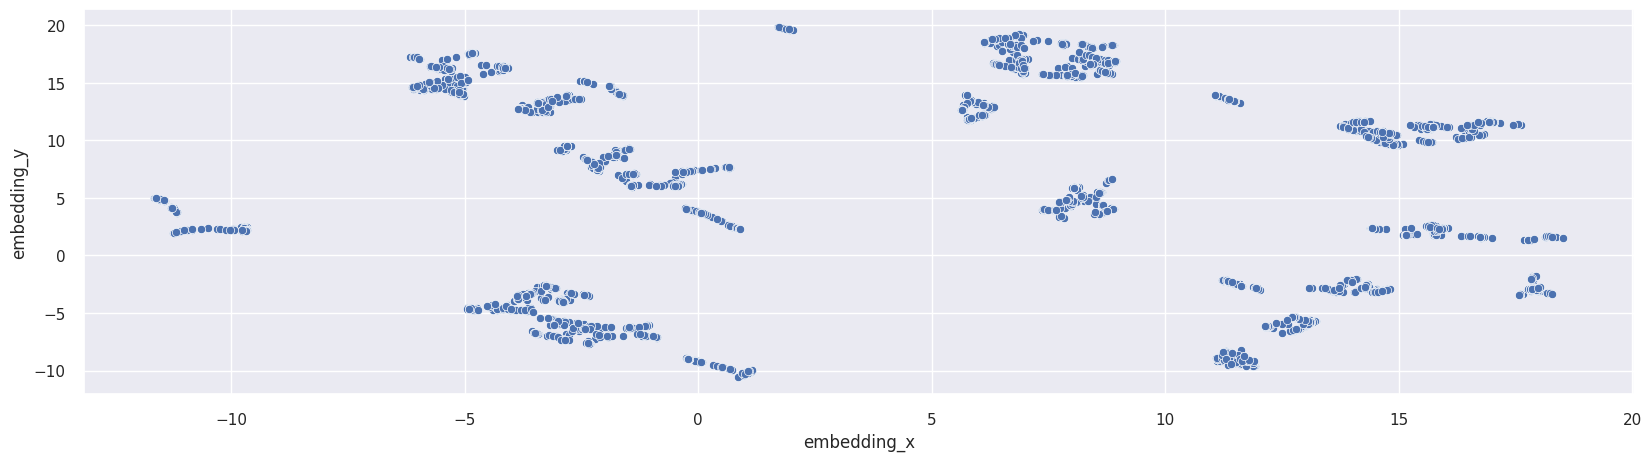

In [155]:
plt.figure(figsize = (20, 5))

# Aplicando um redutor de dimensionalidade
reducer = umap.UMAP(random_state = 42)
embedding = reducer.fit_transform(df_folhas)

# Salvando na máquina local
#pickle.dump(reducer, open('../modelo/umap_reducer.pkl', 'wb'))
# Salvando na nuvem (S3 na AWS)
pickle.dump(reducer, fs.open('s3://cluster-insiders-dataset/umap_reducer.pkl', 'wb')) # Salvando as transformações em arquivo pickle

#Embedding
df_tree = pd.DataFrame()
df_tree['embedding_x'] = embedding[:, 0]
df_tree['embedding_y'] = embedding[:, 1]

# Plotando o UMAP
sns.scatterplot(x = 'embedding_x', y = 'embedding_y', data = df_tree);

# 5. (Modelagem dos dados) Passo 5: Preparação dos dados

In [94]:
# VERIFICAR SE OS DADOS POSSUEM DISTRIBUIÇÃO NORMAL:

# Um método mais robusto para verificar a normalidade dos dados é o uso de gráficos de probabilidade 
# normal (QQ plots). Esses gráficos comparam os quantis empíricos dos dados com os quantis teóricos
# de uma distribuição normal. Se os pontos no gráfico se alinharem aproximadamente ao longo de uma 
# linha reta, isso sugere que os dados podem seguir uma distribuição normal

<Figure size 2000x500 with 0 Axes>

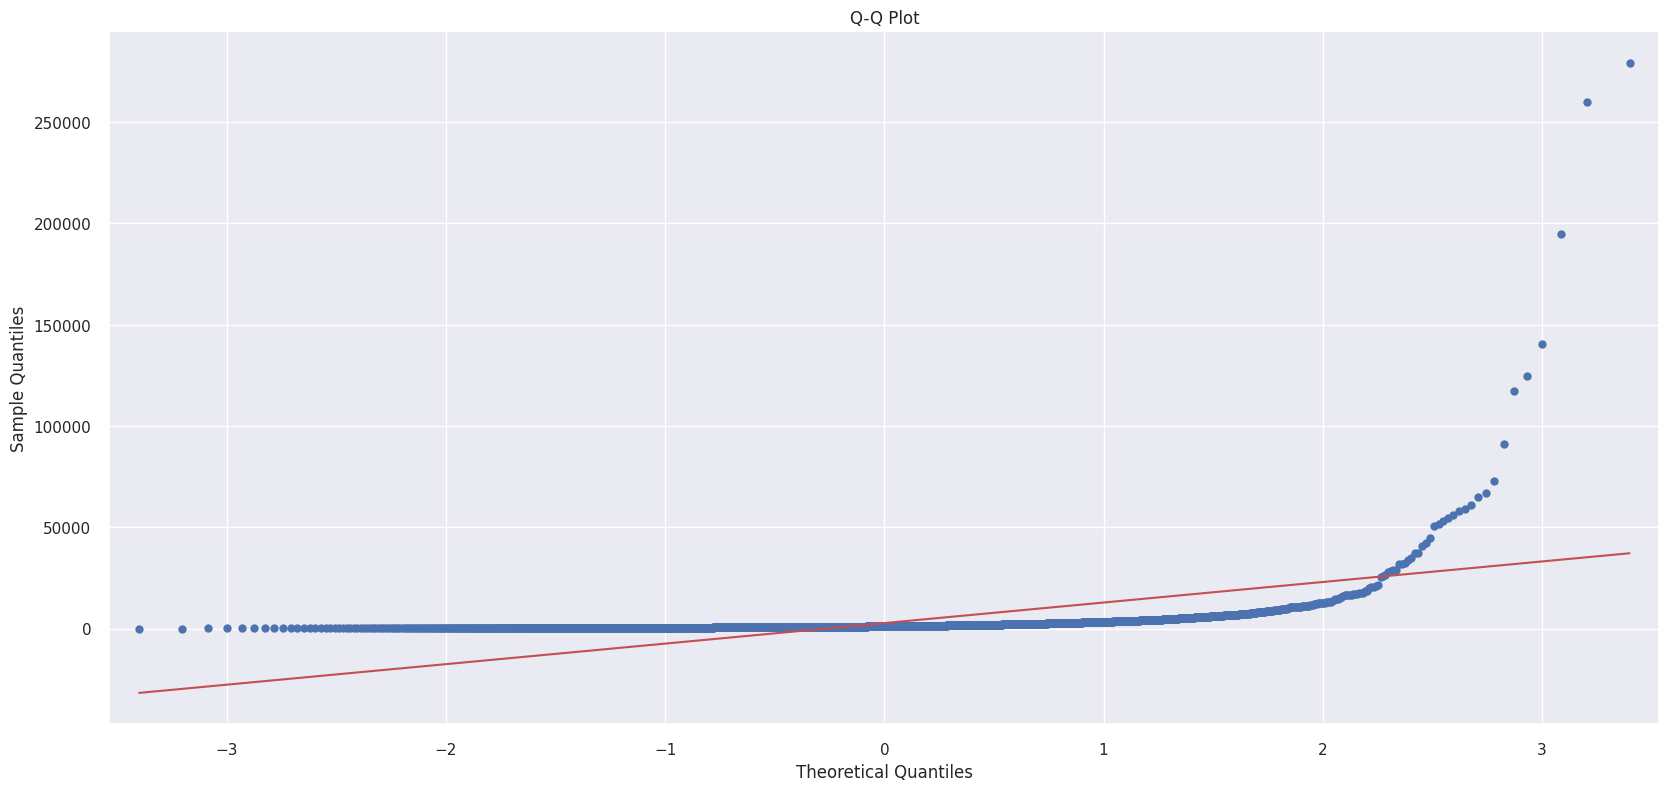

In [95]:
plt.figure(figsize = (20, 5))

sm.qqplot(df4['gross_revenue'], line = 's');
plt.title('Q-Q Plot');
plt.show();

In [96]:
#df5 = df4.copy()
df5 = df_tree.copy() #Está sendo utilizado o df_tree para verificar se os dados no espaço de embedding
# performam melhor que no espaço de variáveis

In [97]:
# REGRAS PARA ESCOLHA DO TIPO DE TRANSFORMAÇÃO:

# 1. Distribuição normal e não possui outliers - > Padronização (StandardScaler)
# Este tipo de transformação de variáveis são indicadas para distribuições normais
# Verificar na análise univariada quais variáveis tem esta caracteristica de distribuição normal
# Média: 0 e desvio padrão: 1

# 2. Distribuição não normal e não possui outliers - > Normalização (MinMaxScaler)
# Este tipo de transformação de variáveis são indicadas para distribuições não normais
# Dados entre 0 e 1

# 3. Distribuição normal e não normal e possui outliers - > Normalização (RobustScaler) 
# Quartis

### <s>5.1 Padronização</s>

### 5.2 Normalização

In [98]:
#mm = pp.MinMaxScaler()

#df5['gross_revenue'] = mm.fit_transform(df5[['gross_revenue']]) #Foi retirado pois agora está sendo utilizado 
# os espaços de embedding
#df5['recency_days'] = mm.fit_transform(df5[['recency_days']]) #Foi retirado pois agora está sendo utilizado 
# os espaços de embedding
#df5['qty_invoices'] = mm.fit_transform(df5[['qty_invoices']]) #Foi retirado pois junto com as variáveis 'qty_invoices', 'qty_products'
# e 'qty_itens' trazem o mesmo tipo de conteúdo de informação e com isso precisaremos escolher somente uma variável
#df5['qty_itens'] = mm.fit_transform(df5[['qty_itens']]) #Foi retirado pois junto com as variáveis 'qty_invoices', 'qty_products'
# e 'qty_itens' trazem o mesmo tipo de conteúdo de informação e com isso precisaremos escolher somente uma variável
#df5['qty_products'] = mm.fit_transform(df5[['qty_products']]) #Foi retirado pois agora está sendo utilizado 
# os espaços de embedding
#df5['avg_ticket'] = mm.fit_transform(df5[['avg_ticket']]) #Foi retirado pois esta variável já é uma média
#df5['avg_recency_days'] = mm.fit_transform(df5[['avg_recency_days']]) #Foi retirado pois esta variável já é uma média
#df5['frequency'] = mm.fit_transform(df5[['frequency']]) #Foi retirado pois agora está sendo utilizado 
# os espaços de embedding
#df5['qty_returns'] = mm.fit_transform(df5[['qty_returns']]) #Foi retirado pois agora está sendo utilizado 
# os espaços de embedding
#df5['avg_basket_size'] = mm.fit_transform(df5[['avg_basket_size']]) #Foi retirado pois esta variável já é uma média
#df5['avg_unique_basket_size'] = mm.fit_transform(df5[['avg_unique_basket_size']]) #Foi retirado pois esta variável já é uma média

In [99]:
df5.head()

,embedding_x,embedding_y
0,-2.943539,-5.953842
1,-10.973037,2.201282
2,-3.242235,-6.958639
3,8.553125,4.461205
4,13.766989,-2.537892


# 6. (Modelagem dos dados) Passo 6: Seleção das variáveis

In [100]:
#cols_selected = ['customer_id', 'gross_revenue', 'recency_days', 'qty_products', 'frequency', 'qty_returns']
#Foi retirado pois agora está sendo utilizado os espaços de embedding

In [101]:
#df6 = df5[cols_selected].copy() #Está sendo utilizado o df_tree para verificar se os dados performam melhor com os espaços de embedding
df6 = df_tree.copy()

# 7. (Algoritmos de Ml) Passo 7: Ajuste dos hiperparâmetros no algoritmo

In [102]:
#df7 = df6.drop(columns = ['customer_id'], axis = 1)
#x = df7.copy() #Está sendo utilizado o df_tree para verificar se os dados performam 
# melhor com os espaços de embedding
x = df_tree.copy()

In [103]:
x.head()

,embedding_x,embedding_y
0,-2.943539,-5.953842
1,-10.973037,2.201282
2,-3.242235,-6.958639
3,8.553125,4.461205
4,13.766989,-2.537892


In [104]:
#clusters = [2, 3, 4, 5, 6, 7]
clusters = np.arange(2, 31, 1)

### 7.1 Algoritmo K-means

In [105]:
kmeans_list = list()

for k in clusters:    
    # Definição do modelo
    kmeans = c.KMeans(n_clusters = k, n_init = 100, random_state = 42)
    
    # Treinamento do modelo
    kmeans.fit(x)
    
    # Predição do modelo
    labels = kmeans.predict(x)

    # Performance do modelo
    sil = m.silhouette_score(x, labels, metric = 'euclidean')
    kmeans_list.append(sil)

KMeans(n_clusters=2, n_init=100, random_state=42)

KMeans(n_clusters=3, n_init=100, random_state=42)

KMeans(n_clusters=4, n_init=100, random_state=42)

KMeans(n_clusters=5, n_init=100, random_state=42)

KMeans(n_clusters=6, n_init=100, random_state=42)

KMeans(n_clusters=7, n_init=100, random_state=42)

KMeans(n_init=100, random_state=42)

KMeans(n_clusters=9, n_init=100, random_state=42)

KMeans(n_clusters=10, n_init=100, random_state=42)

KMeans(n_clusters=11, n_init=100, random_state=42)

KMeans(n_clusters=12, n_init=100, random_state=42)

KMeans(n_clusters=13, n_init=100, random_state=42)

KMeans(n_clusters=14, n_init=100, random_state=42)

KMeans(n_clusters=15, n_init=100, random_state=42)

KMeans(n_clusters=16, n_init=100, random_state=42)

KMeans(n_clusters=17, n_init=100, random_state=42)

KMeans(n_clusters=18, n_init=100, random_state=42)

KMeans(n_clusters=19, n_init=100, random_state=42)

KMeans(n_clusters=20, n_init=100, random_state=42)

KMeans(n_clusters=21, n_init=100, random_state=42)

KMeans(n_clusters=22, n_init=100, random_state=42)

KMeans(n_clusters=23, n_init=100, random_state=42)

KMeans(n_clusters=24, n_init=100, random_state=42)

KMeans(n_clusters=25, n_init=100, random_state=42)

KMeans(n_clusters=26, n_init=100, random_state=42)

KMeans(n_clusters=27, n_init=100, random_state=42)

KMeans(n_clusters=28, n_init=100, random_state=42)

KMeans(n_clusters=29, n_init=100, random_state=42)

KMeans(n_clusters=30, n_init=100, random_state=42)

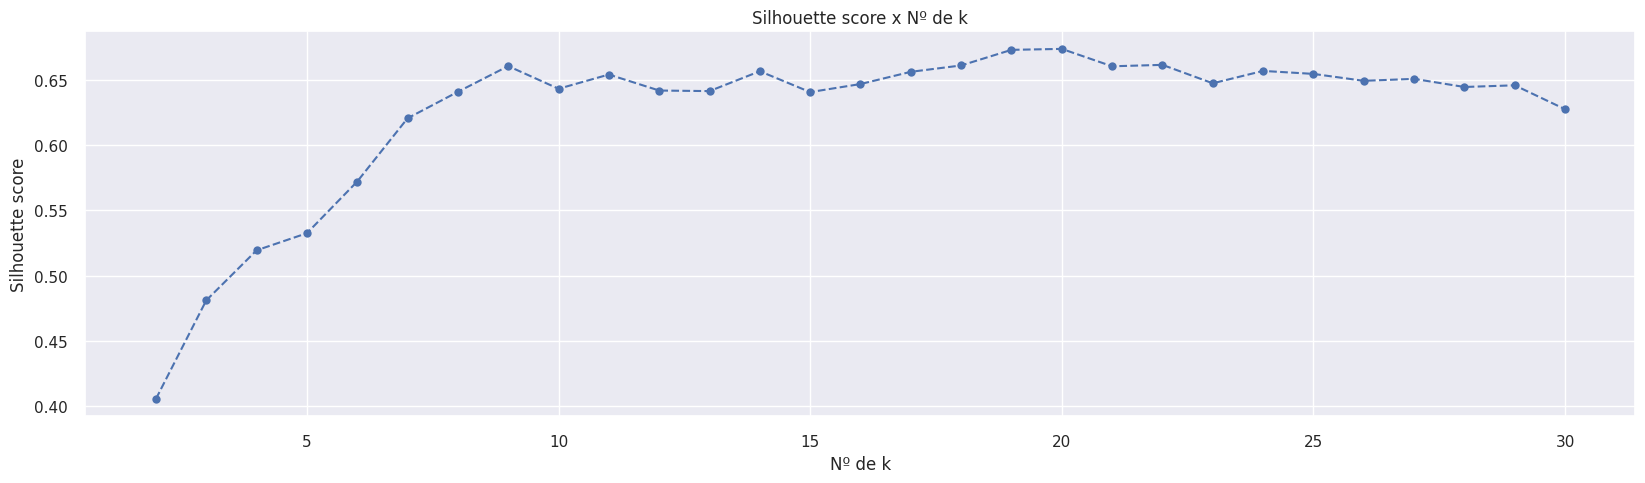

In [106]:
plt.figure(figsize = (20, 5))

plt.plot(clusters, kmeans_list, linestyle = '--', marker = 'o', color = 'b')
plt.xlabel('Nº de k')
plt.ylabel('Silhouette score')
plt.title('Silhouette score x Nº de k');

### 7.2 Algoritmo GMM (Modelo de Mezcla Gaussiana)

In [107]:
gmm_list = list()

for k in clusters:    
    # Definição do modelo
    gmm = mx.GaussianMixture(n_components = k, n_init = 100, random_state = 42)
    
    # Treinamento do modelo
    gmm.fit(x)
    
    # Predição do modelo
    labels = gmm.predict(x)

    # Performance do modelo
    sil = m.silhouette_score(x, labels, metric = 'euclidean')
    gmm_list.append(sil)

GaussianMixture(n_components=2, n_init=100, random_state=42)

GaussianMixture(n_components=3, n_init=100, random_state=42)

GaussianMixture(n_components=4, n_init=100, random_state=42)

GaussianMixture(n_components=5, n_init=100, random_state=42)

GaussianMixture(n_components=6, n_init=100, random_state=42)

GaussianMixture(n_components=7, n_init=100, random_state=42)

GaussianMixture(n_components=8, n_init=100, random_state=42)

GaussianMixture(n_components=9, n_init=100, random_state=42)

GaussianMixture(n_components=10, n_init=100, random_state=42)

GaussianMixture(n_components=11, n_init=100, random_state=42)

GaussianMixture(n_components=12, n_init=100, random_state=42)

GaussianMixture(n_components=13, n_init=100, random_state=42)

GaussianMixture(n_components=14, n_init=100, random_state=42)

GaussianMixture(n_components=15, n_init=100, random_state=42)

GaussianMixture(n_components=16, n_init=100, random_state=42)

GaussianMixture(n_components=17, n_init=100, random_state=42)

GaussianMixture(n_components=18, n_init=100, random_state=42)

GaussianMixture(n_components=19, n_init=100, random_state=42)

GaussianMixture(n_components=20, n_init=100, random_state=42)

GaussianMixture(n_components=21, n_init=100, random_state=42)

GaussianMixture(n_components=22, n_init=100, random_state=42)

GaussianMixture(n_components=23, n_init=100, random_state=42)

GaussianMixture(n_components=24, n_init=100, random_state=42)

GaussianMixture(n_components=25, n_init=100, random_state=42)

GaussianMixture(n_components=26, n_init=100, random_state=42)

GaussianMixture(n_components=27, n_init=100, random_state=42)

GaussianMixture(n_components=28, n_init=100, random_state=42)

GaussianMixture(n_components=29, n_init=100, random_state=42)

GaussianMixture(n_components=30, n_init=100, random_state=42)

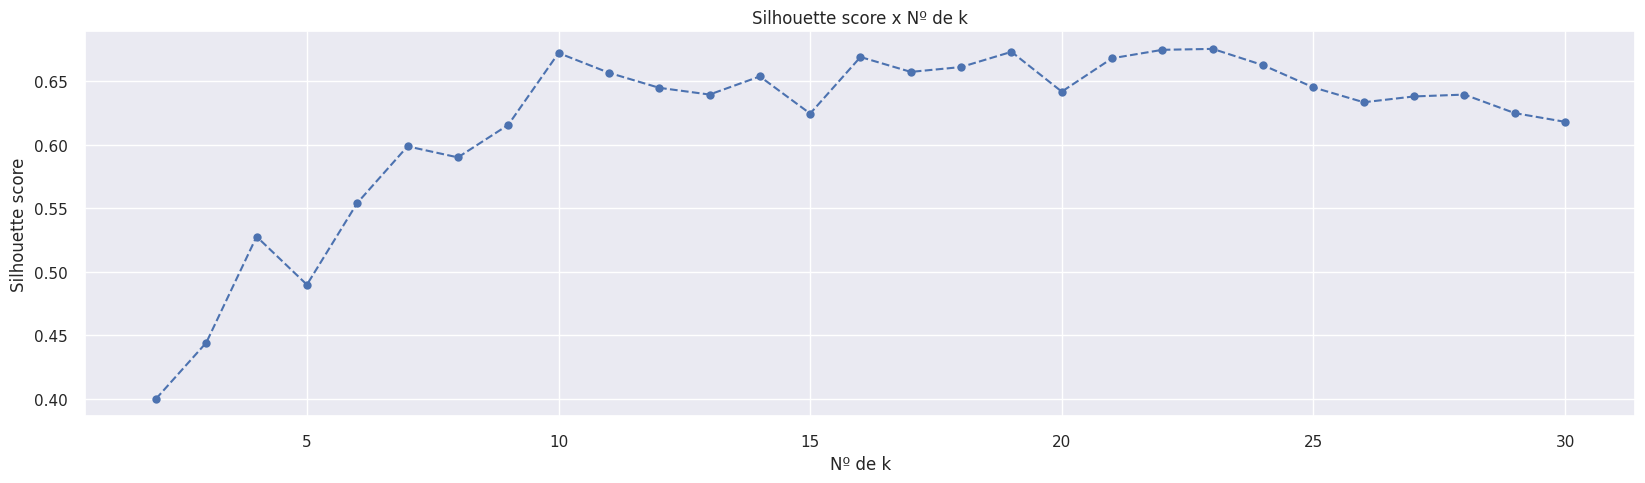

In [108]:
plt.figure(figsize = (20, 5))

plt.plot(clusters, gmm_list, linestyle = '--', marker = 'o', color = 'b')
plt.xlabel('Nº de k')
plt.ylabel('Silhouette score')
plt.title('Silhouette score x Nº de k');

### 7.3 Algoritmo Hierárquico

In [109]:
hc_list = list()

for k in clusters:    
    # Definição e treinamento do modelo
    hc = hcy.linkage(x, 'ward')
    
    # Predição do modelo
    labels = hcy.fcluster(hc, k, criterion = 'maxclust')

    # Performance do modelo
    sil = m.silhouette_score(x, labels, metric = 'euclidean')
    hc_list.append(sil)

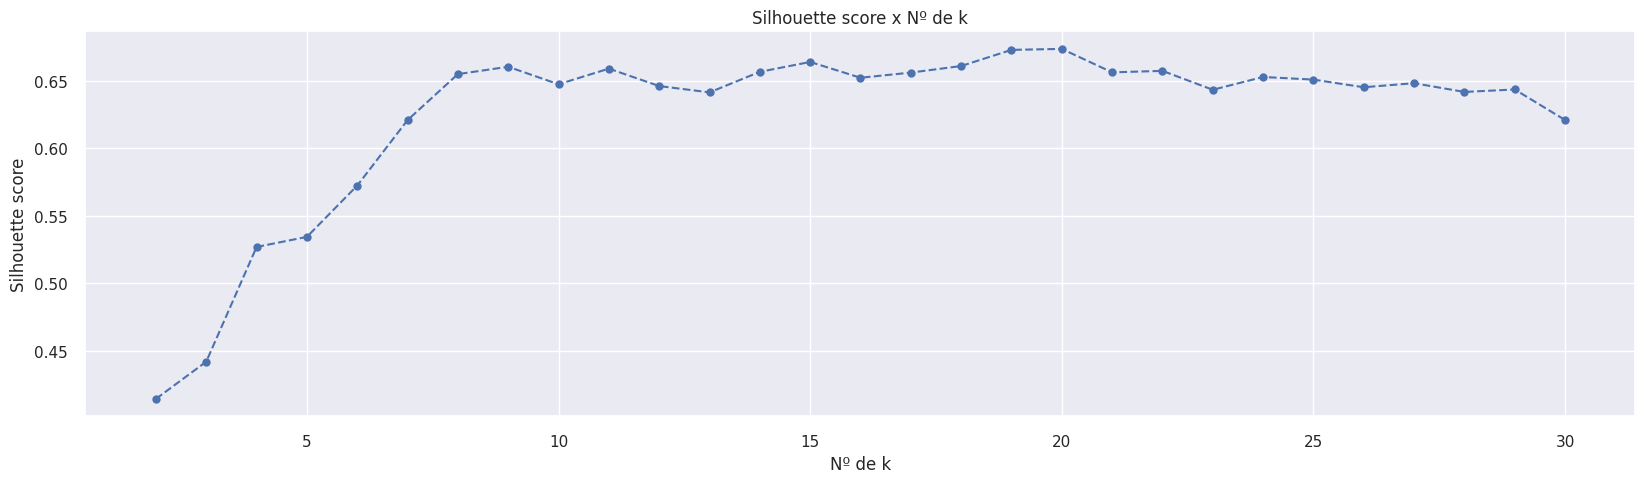

In [110]:
plt.figure(figsize = (20, 5))

plt.plot(clusters, hc_list, linestyle = '--', marker = 'o', color = 'b')
plt.xlabel('Nº de k')
plt.ylabel('Silhouette score')
plt.title('Silhouette score x Nº de k');

#### 7.3.1 Gráfico Dendrograma

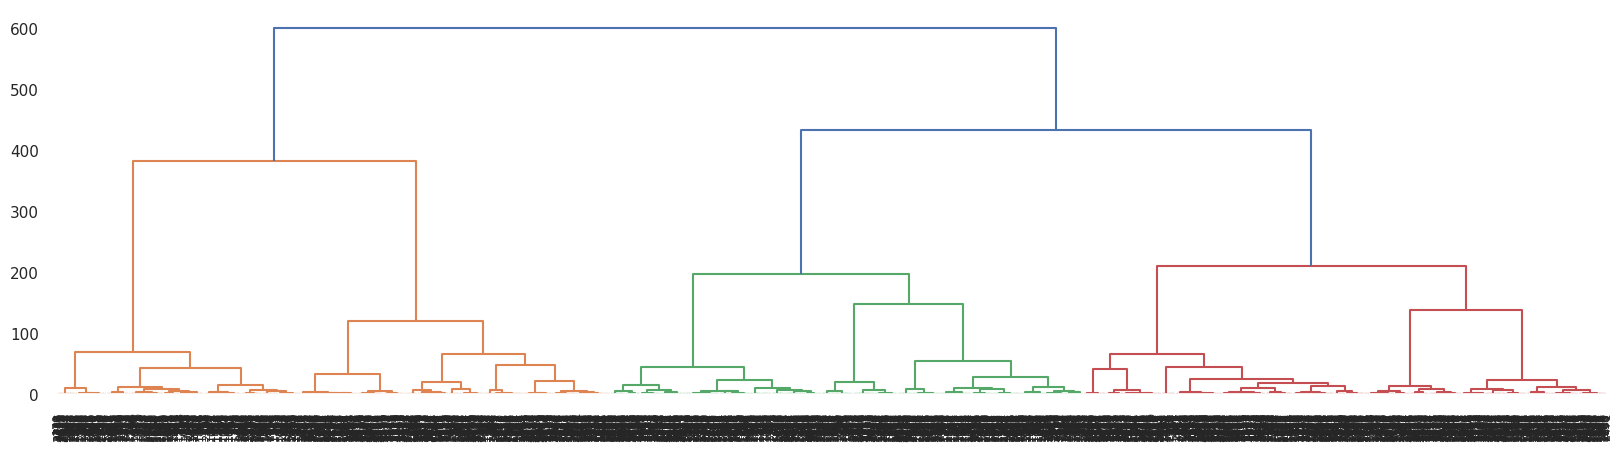

In [111]:
plt.figure(figsize = (20, 5))

dendrogram_output = hcy.dendrogram(hc, leaf_rotation = 90, leaf_font_size = 8)
plt.show();

##### 7.3.1.1 Gráfico Dendrograma resumido

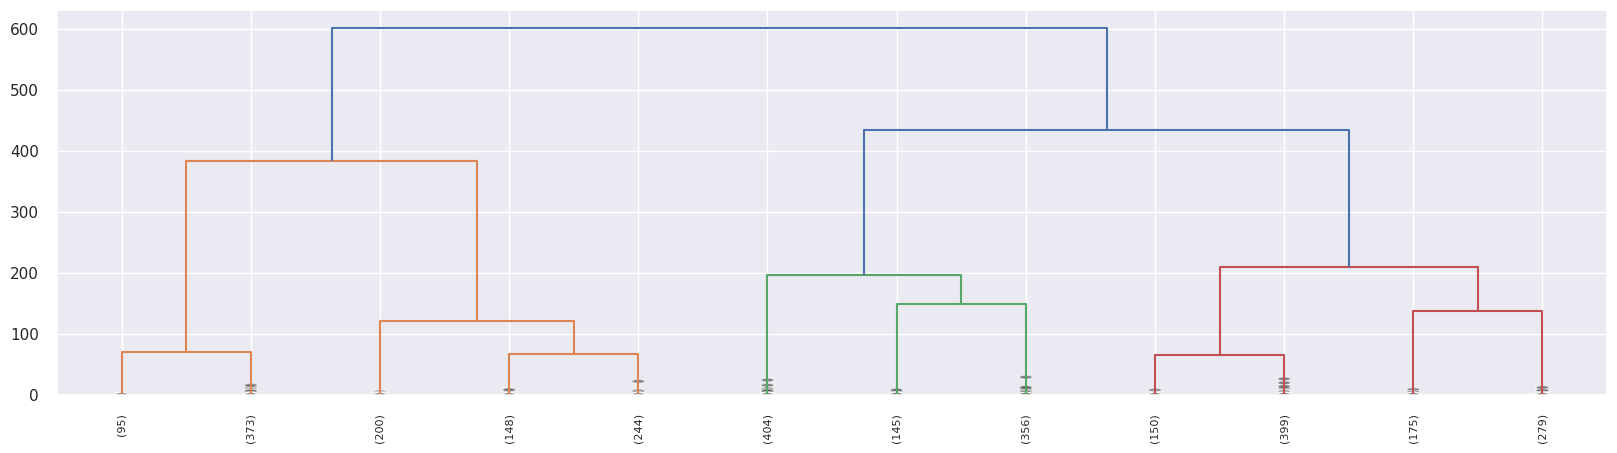

In [112]:
plt.figure(figsize = (20, 5))

dendrogram_output = hcy.dendrogram(hc, 
                                   truncate_mode = 'lastp',
                                   p = 12,
                                   leaf_rotation = 90,
                                   leaf_font_size = 8,
                                   show_contracted = True)
plt.show();

### 7.4 Algoritmo DBSCAN (Density-Based Spatial Clustering of Applications with Noise)

In [113]:
eps = 2 # eps -> raio
min_samples = 20 # min_samples = nº de densidade ou nº de pontos no cluster

# Definição do modelo
dbscan = c.DBSCAN(eps = eps, min_samples = min_samples)
    
# Treinamento e predição do modelo
labels = dbscan.fit_predict(x)

# Performance do modelo
sil = m.silhouette_score(x, labels, metric = 'euclidean')
sil

0.683477

### 7.5 Resultados dos Algoritmos

In [114]:
#df_resultado = pd.DataFrame({'Kmeans': kmeans_list,
#                             'GMM': gmm_list,
#                             'HC': hc_list,
#                             'DBSCAN': dbscan_list}).T

In [115]:
df_resultado = pd.DataFrame({'Kmeans': kmeans_list,
                             'GMM': gmm_list,
                             'HC': hc_list}).T

In [116]:
df_resultado.columns = clusters
df_resultado.style.highlight_max(color = 'red', axis = 1)

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30
Kmeans,0.405573,0.481031,0.519365,0.532469,0.572069,0.620502,0.640759,0.660459,0.643105,0.654004,0.641741,0.641311,0.656526,0.640537,0.646716,0.656080,0.660946,0.672906,0.673640,0.660313,0.661409,0.647288,0.656769,0.654485,0.649179,0.650685,0.644466,0.645745,0.627449
GMM,0.400073,0.444266,0.527649,0.489848,0.554067,0.598613,0.589934,0.615456,0.671997,0.656462,0.644633,0.639327,0.653576,0.624364,0.668840,0.657135,0.660961,0.672921,0.641613,0.667859,0.674495,0.675226,0.662401,0.644939,0.633266,0.637850,0.639289,0.624746,0.617880
HC,0.414386,0.441967,0.526932,0.534397,0.572393,0.620900,0.654967,0.660412,0.647445,0.659029,0.646128,0.641438,0.656654,0.663973,0.652269,0.656094,0.660961,0.672921,0.673655,0.656280,0.657376,0.643370,0.652851,0.650893,0.645237,0.648247,0.641763,0.643587,0.620996


### 7.6 Análise da Silhouette

In [117]:
clusters = np.arange(2, 10, 1)

#### 7.6.1 Algoritmo K-means

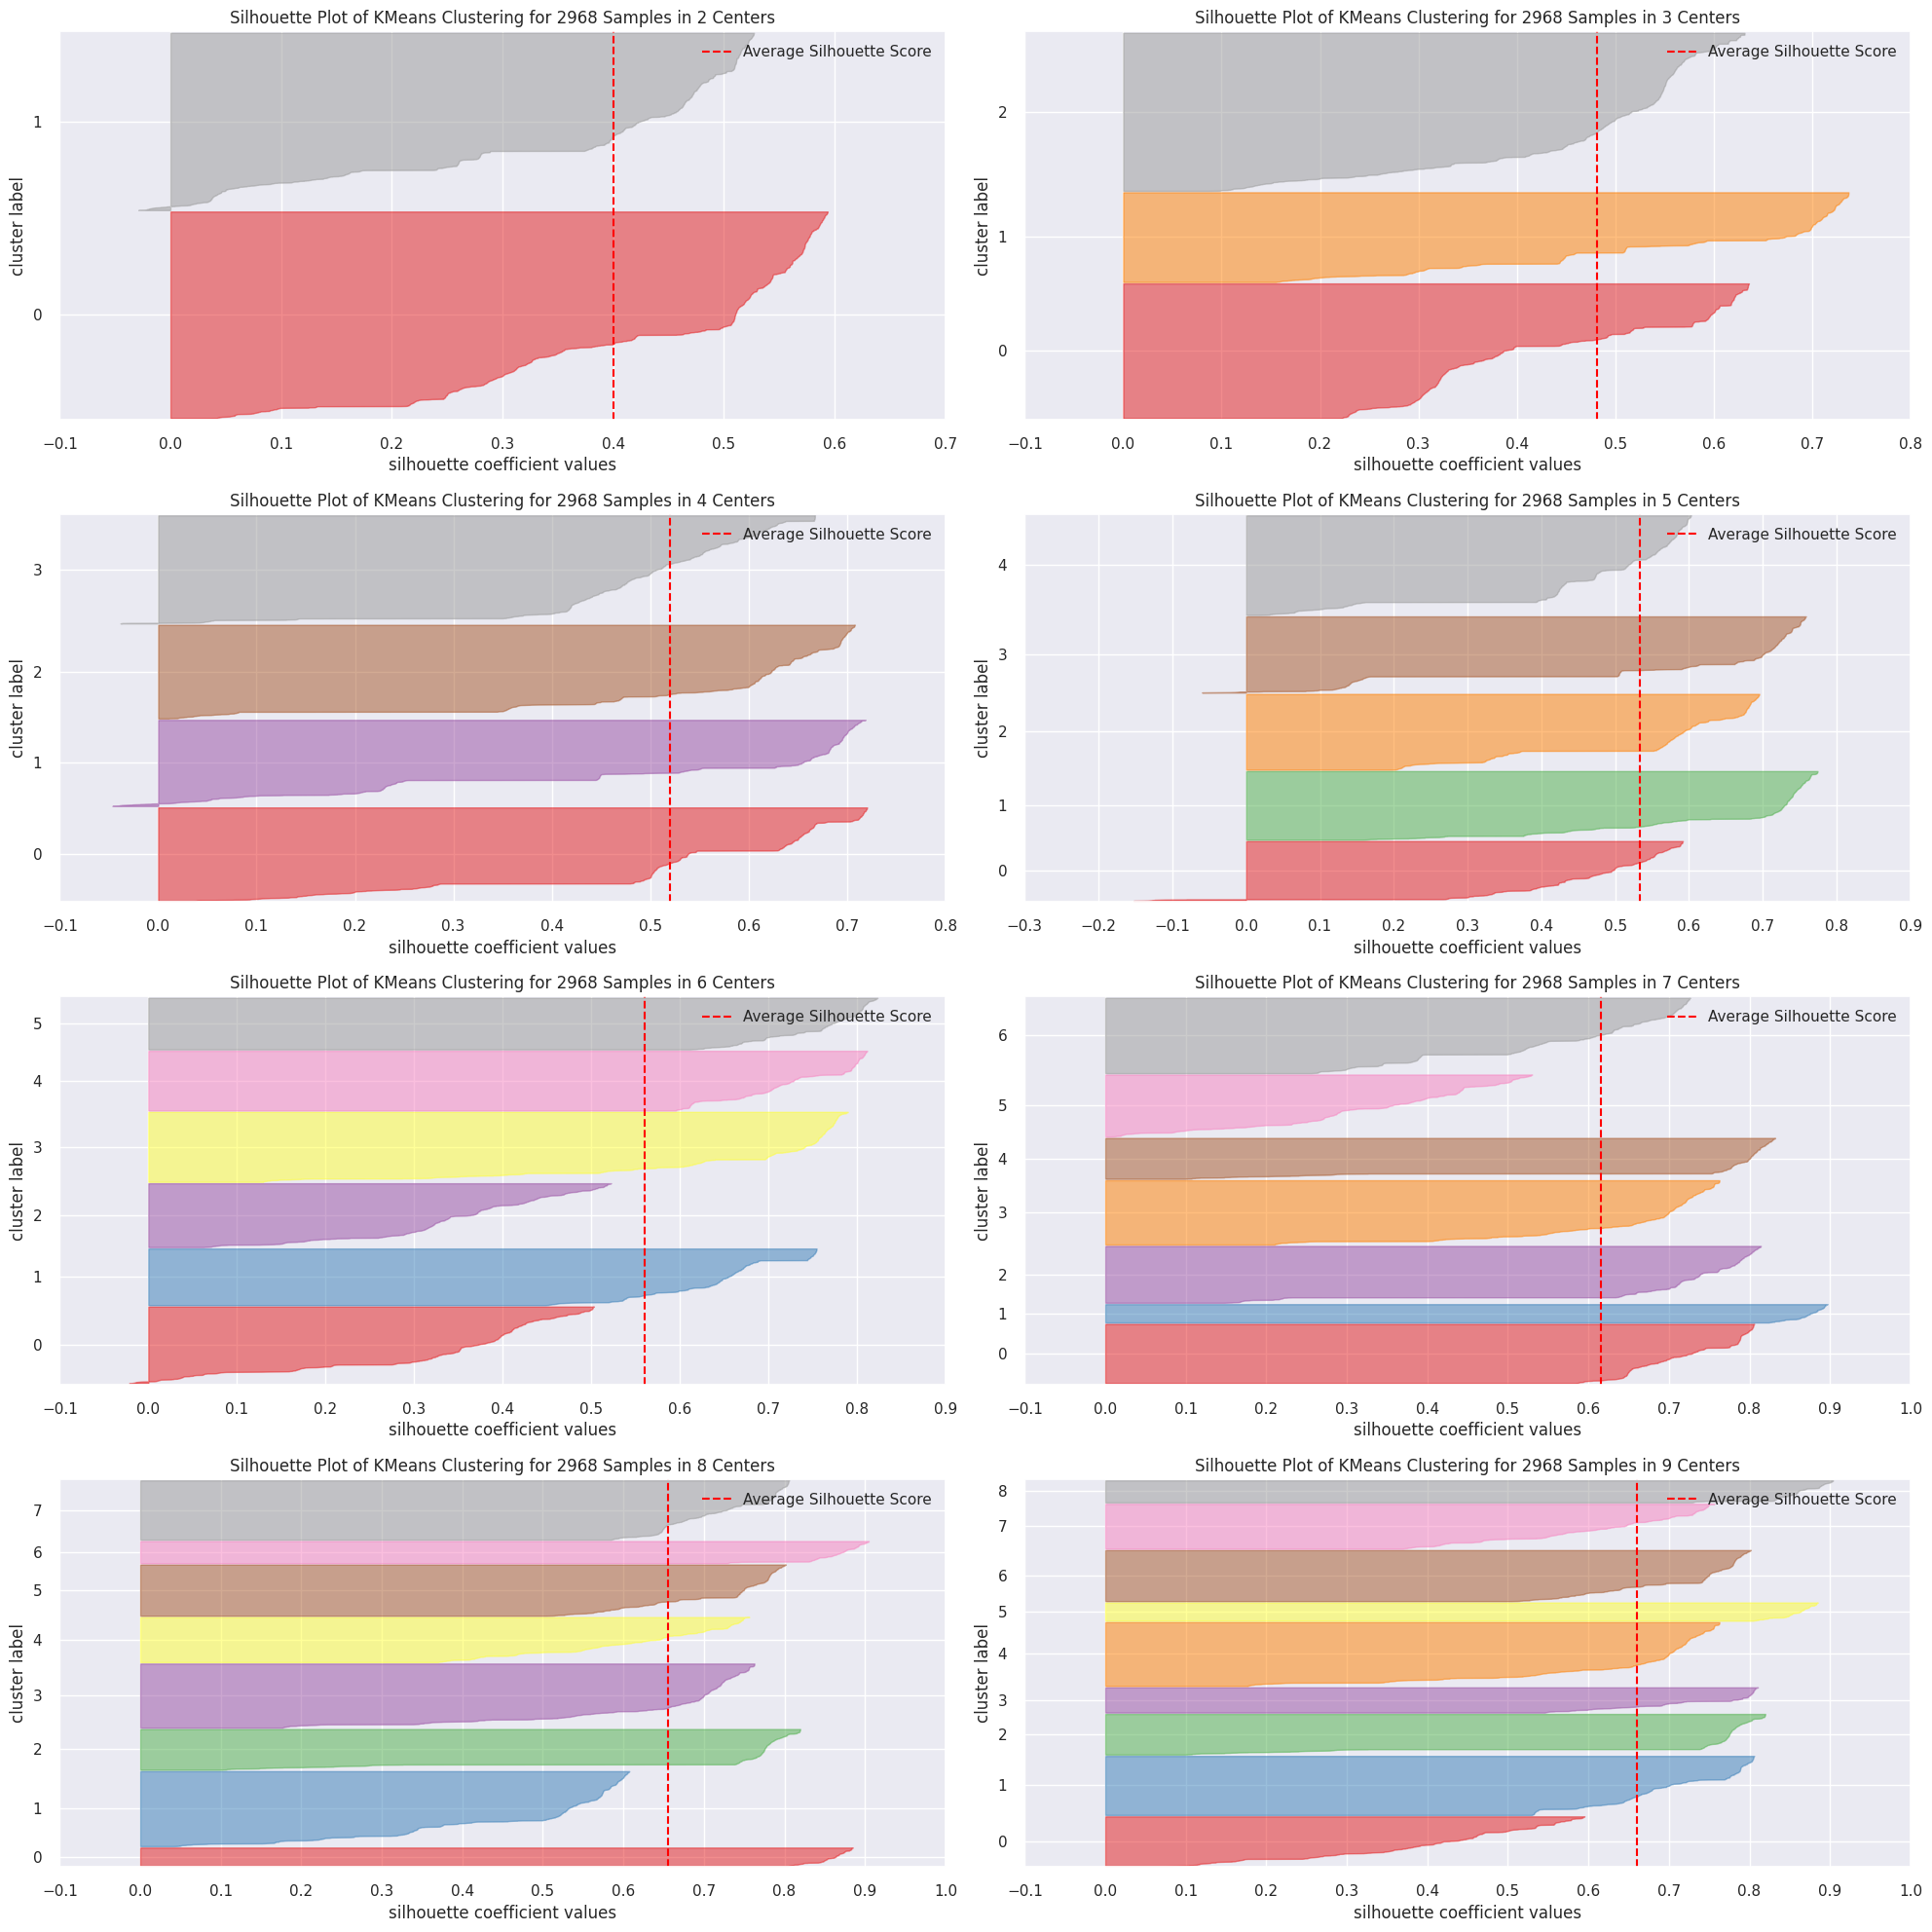

In [118]:
# Calcula o número de linhas e colunas necessárias para a disposição dos subplots
num_rows, num_cols = divmod(len(clusters), 2)
if num_cols > 0:
    num_rows += 1

# Ajusta o número total de subplots
fig, ax = plt.subplots(num_rows, 2, figsize=(20, 5 * num_rows))

# Itera sobre o número total de clusters ou subplots
for i, k in enumerate(clusters):
    km = c.KMeans(init = 'random', n_clusters = k, n_init = 10, max_iter = 100, random_state = 42)
    
    # Calcula as coordenadas do subplot
    subplot_row, subplot_col = np.unravel_index(i, (num_rows, 2))
    
    visualizer = SilhouetteVisualizer(km, color = 'yellowbrick', ax = ax[subplot_row][subplot_col])
    visualizer.fit(x)
    visualizer.finalize()

# Exclui o último subplot vazio, se necessário
if num_cols > 0:
    fig.delaxes(ax[-1, -1])

plt.tight_layout()
plt.show();

#### 7.6.2 Algoritmo GMM

Para k: 2 -> silhouette score: 0.4143858551979065
Para k: 3 -> silhouette score: 0.4381335377693176
Para k: 4 -> silhouette score: 0.5276491641998291
Para k: 5 -> silhouette score: 0.5396338701248169
Para k: 6 -> silhouette score: 0.5723927617073059
Para k: 7 -> silhouette score: 0.576107382774353
Para k: 8 -> silhouette score: 0.6549672484397888
Para k: 9 -> silhouette score: 0.6184601783752441


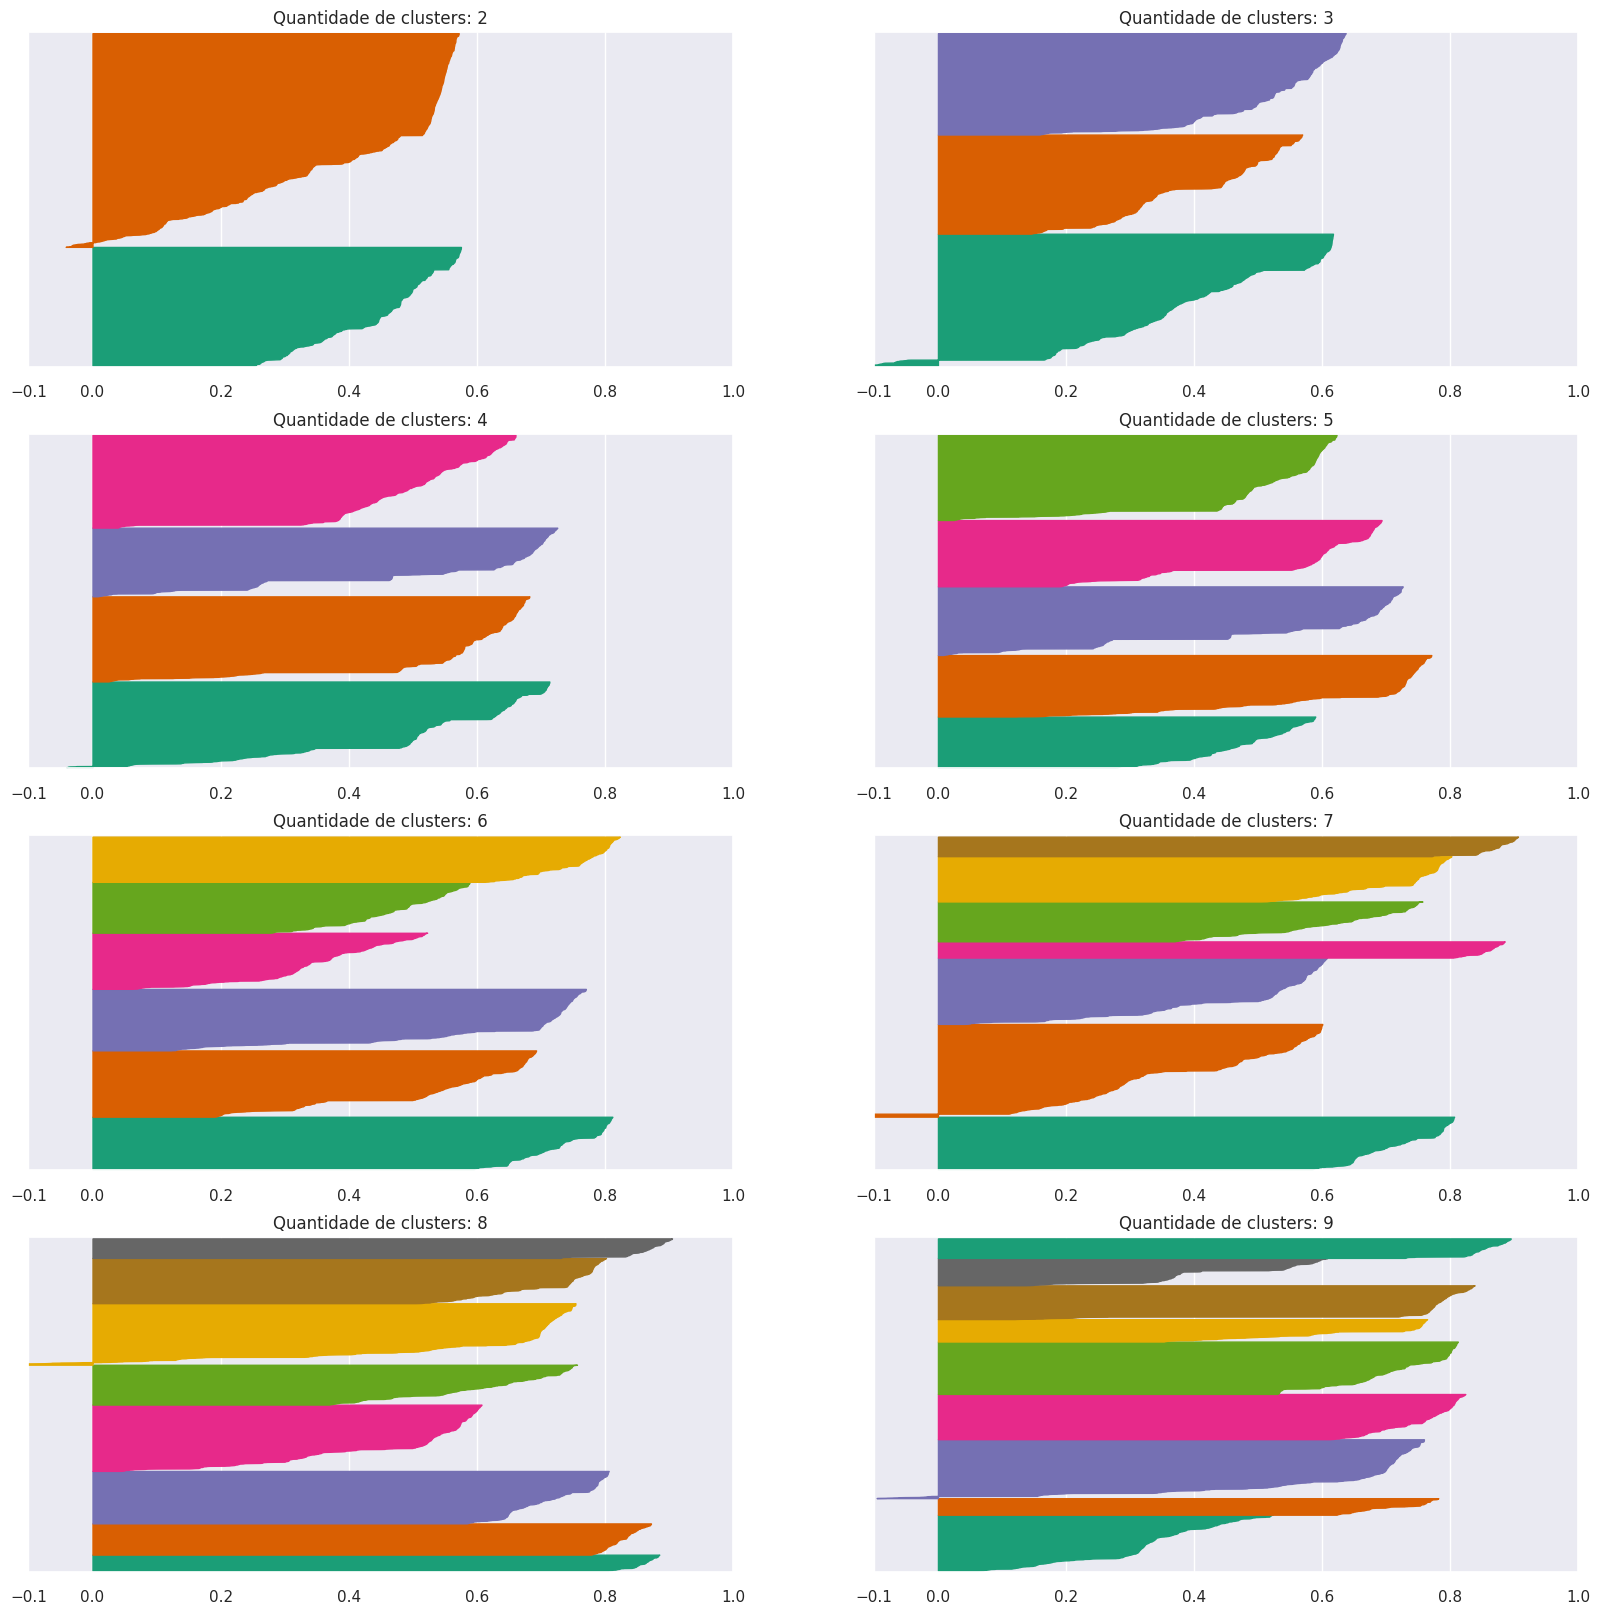

In [119]:
# Determinando o número de linhas e colunas com base no comprimento de clusters
n_clusters = len(clusters)
n_cols = 2
n_rows = -(-n_clusters // n_cols)  # Arredondando para cima a divisão

fig, ax = plt.subplots(n_rows, n_cols)
fig.set_size_inches(20, n_rows * 5)  # Ajuste a altura conforme necessário

# Número de clusters que será testado
for k in clusters:
    q, mod = divmod(k, n_cols)  # q -> linha, mod -> coluna

    # Predição do modelo
    gmm = mx.GaussianMixture(n_components = k)
    labels = gmm.fit_predict(x)

    # Performance do modelo
    sil = m.silhouette_score(x, labels, metric = 'euclidean')
    print('Para k: {} -> silhouette score: {}'.format(k, sil))

    # Obtendo os valores individuais de cada silhouette
    samples_silhouette_values = m.silhouette_samples(x, labels)

    y_lower = 10

    # Percorrendo o nº de clusters
    for i in range(k):
        # Selecionando os clusters
        ith_samples_silhouette_values = samples_silhouette_values[labels == i]

        # Classificando os clusters
        ith_samples_silhouette_values.sort()

        # Tamanho dos clusters
        size_cluster_i = ith_samples_silhouette_values.shape[0]

        # Limite do cluster
        y_upper = y_lower + size_cluster_i

        # Inserindo cores nos clusters
        #cmap = cm.get_cmap('Spectral')
        #color = cmap(i / k)
        cmap = cm.get_cmap('Dark2')
        color = cmap(i % cmap.N)
        
        # Preenchendo a linha do silhouette com a cor
        ax[q - 1, mod].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_samples_silhouette_values, color = color, label = f'Cluster {i + 1}')
        y_lower = y_upper + 0 # Espaçamento entre os clusters

    ax[q - 1, mod].set_xlim([-0.1, 1])
    ax[q - 1, mod].set_ylim([0, y_upper + 10])  # Ajuste para incluir a última linha de silhouette

    ax[q - 1, mod].set_yticks([])
    ax[q - 1, mod].set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # Adicionando título com a quantidade de clusters
    ax[q - 1, mod].set_title('Quantidade de clusters: {}'.format(k))
         
    # Removendo a legenda anterior
    ax[q - 1, mod].legend().set_visible(False)

# Removendo os subplots não utilizados
for i in range(n_clusters, n_rows * n_cols):
    fig.delaxes(ax.flatten()[i])

plt.show();

#### 7.6.3 Algoritmo Hierárquico

Para k: 2 -> silhouette score: 0.4143858551979065
Para k: 3 -> silhouette score: 0.44196707010269165
Para k: 4 -> silhouette score: 0.526931643486023
Para k: 5 -> silhouette score: 0.5343974232673645
Para k: 6 -> silhouette score: 0.5723927617073059
Para k: 7 -> silhouette score: 0.6209003329277039
Para k: 8 -> silhouette score: 0.6549672484397888
Para k: 9 -> silhouette score: 0.6604120135307312


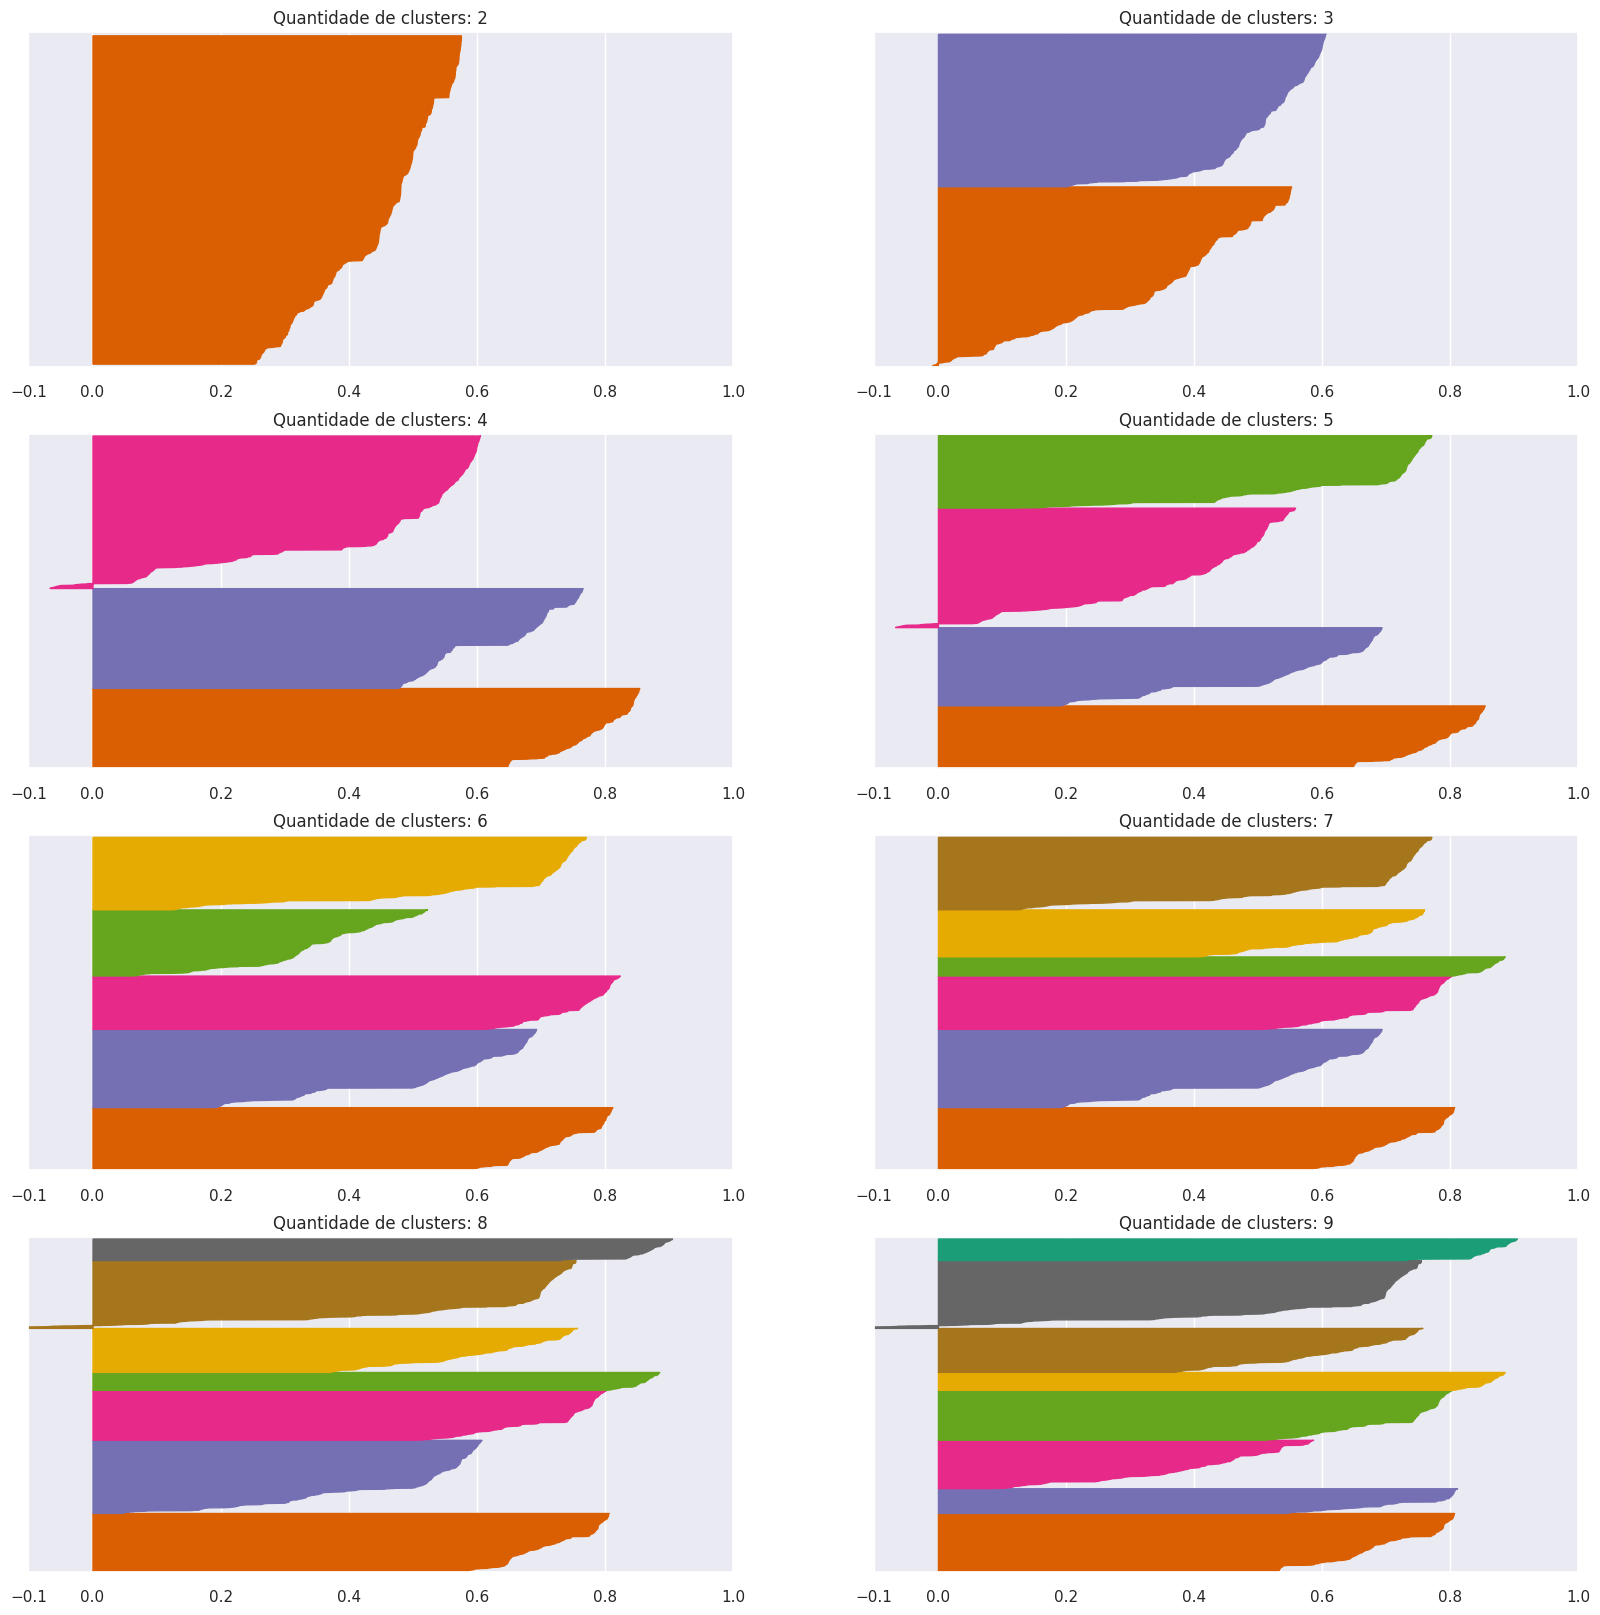

In [120]:
# Defina o modelo de ligação fora do loop
hc = hcy.linkage(x, 'ward')

# Determinando o número de linhas e colunas com base no comprimento de clusters
n_clusters = len(clusters)
n_cols = 2
n_rows = -(-n_clusters // n_cols)  # Arredondando para cima a divisão

fig, ax = plt.subplots(n_rows, n_cols)
fig.set_size_inches(20, n_rows * 5)  # Ajuste a altura conforme necessário

# Número de clusters que será testado
for k in clusters:
    q, mod = divmod(k, n_cols)  # q -> linha, mod -> coluna

    # Predição do modelo
    labels = hcy.fcluster(hc, k, criterion = 'maxclust')

    # Performance do modelo
    sil = m.silhouette_score(x, labels, metric = 'euclidean')
    print('Para k: {} -> silhouette score: {}'.format(k, sil))

    # Obtendo os valores individuais de cada silhouette
    samples_silhouette_values = m.silhouette_samples(x, labels)

    y_lower = 10

    # Percorrendo o nº de clusters
    for i in range(k):
        # Selecionando os clusters
        ith_samples_silhouette_values = samples_silhouette_values[labels == i]

        # Classificando os clusters
        ith_samples_silhouette_values.sort()

        # Tamanho dos clusters
        size_cluster_i = ith_samples_silhouette_values.shape[0]

        # Limite do cluster
        y_upper = y_lower + size_cluster_i

        # Inserindo cores nos clusters
        cmap = cm.get_cmap('Dark2')
        color = cmap(i % cmap.N)
        
        # Preenchendo a linha do silhouette com a cor
        ax[q - 1, mod].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_samples_silhouette_values, color = color, label = f'Cluster {i + 1}')
        y_lower = y_upper + 0 # Espaçamento entre os clusters

    ax[q - 1, mod].set_xlim([-0.1, 1])
    ax[q - 1, mod].set_ylim([0, y_upper + 10])  # Ajuste para incluir a última linha de silhouette

    ax[q - 1, mod].set_yticks([])
    ax[q - 1, mod].set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # Adicionando título com a quantidade de clusters
    ax[q - 1, mod].set_title('Quantidade de clusters: {}'.format(k))
         
    # Removendo a legenda anterior
    ax[q - 1, mod].legend().set_visible(False)

# Removendo os subplots não utilizados
for i in range(n_clusters, n_rows * n_cols):
    fig.delaxes(ax.flatten()[i])

plt.show();

### 7.1 Within-Cluster Sum of Square (WSS)

In [121]:
# Para problemas de clusterização, é necessário 'chutar valores' e depois avaliar 
# a métrica para assim saber primeiro quantos cluster tem o conjunto de dados

In [122]:
#clusters = [2, 3, 4, 5, 6, 7]

In [123]:
#plt.figure(figsize = (20, 5))

#wss = list()
#for k in clusters:
#    # Definição do modelo
#    kmeans = c.KMeans(init = 'random', n_clusters = k, n_init = 10, max_iter = 300, random_state = 42)
    
#    # Treinamento do modelo
#    kmeans.fit(x)
    
#    # Validação do modelo
#    wss.append(kmeans.inertia_)

## Inserindo o gráfico de cotovelo, 'Elbow method'
#plt.plot(clusters, wss, linestyle = '--', marker = 'o', color = 'b')
#plt.xlabel('k')
#plt.ylabel('Within-Cluster Sum of Square (WSS)')
#plt.title('WSS vs k');

In [124]:
# Escolher o ponto onde tem a maior variação, ou seja, um cotovelo, neste caso existem o k = 3 e k = 5 

### 7.2 Outra maneira de implementar Within-Cluster Sum of Square (WSS)

In [125]:
#plt.figure(figsize = (20, 5))

#kmeans = KElbowVisualizer(c.KMeans(), k = clusters, timings = False)
#kmeans.fit(x)
#kmeans.show();

### 7.3 Silhouette Score

In [126]:
#plt.figure(figsize = (20, 5))

#kmeans = KElbowVisualizer(c.KMeans(), k = clusters, metric = 'silhouette', timings = False)
#kmeans.fit(x)
#kmeans.show();

# 8. (Algoritmos de Ml) Passo 8: Implementar os modelos de machine learning

### <s>8.1 Algoritmo K-means</s>

In [127]:
# Definição do modelo
#k = 11 # Foi escolhido este valor depois que fizemos o teste com as métricas acima, poderia
# ser usado o k = 22 (maior métrica), contudo muitos clusters não seria interessante para gerenciar
# pensando no time de marketing, então optou-se para 11 clusters, que também é qtde dos quadrinhos
# no gráfico RFM do curso
#kmeans = c.KMeans(init = 'random', n_clusters = k, n_init = 10, max_iter = 300, random_state = 42)
    
# Treinamento do modelo
#kmeans.fit(x)
    
# clusterizando
#labels = kmeans.labels_

### 8.2 Algoritmo GMM (Modelo de Mezcla Gaussiana)

In [128]:
k = 8

# Definição do modelo
gmm = mx.GaussianMixture(n_components = k, n_init = 300, random_state = 42)
    
# Treinamento do modelo
gmm.fit(x)
    
# Predição do modelo
labels = gmm.predict(x)

GaussianMixture(n_components=8, n_init=300, random_state=42)

#### 8.1.1 Métrica WSS

In [129]:
#kmeans.inertia_

#### 8.1.2 Métrica Silhouette

In [130]:
m.silhouette_score(x, labels)

0.58993447

In [131]:
np.unique(labels)

array([0, 1, 2, 3, 4, 5, 6, 7])

# 9. (Algoritmos de Ml) Passo 9: Análise dos clusters

In [132]:
#df9 = df4.copy() #Está sendo utilizado o df_tree para verificar se os dados performam melhor com os espaços de embedding
#df9['cluster'] = labels
df9 = x.copy()
df9['cluster'] = labels

In [133]:
#df_viz = df9.drop(columns = 'customer_id', axis = 1)

### 9.1 Visualização final dos clusters

#### 9.1.1 Algoritmos de Embedding (Redução de dimensionalidade para 2d)

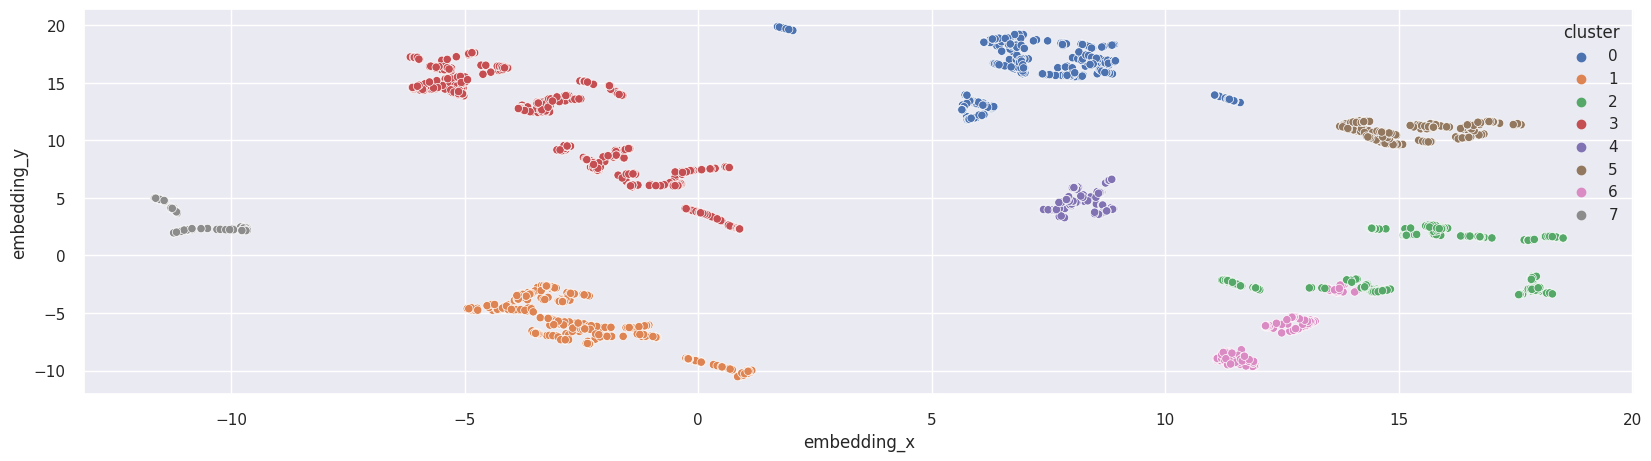

In [134]:
# Plotando o UMAP pois agora está sendo utilizado 
# os espaços de embedding
plt.figure(figsize = (20, 5))

sns.scatterplot(x = 'embedding_x', 
                y = 'embedding_y',
                hue = 'cluster',
                palette = 'deep',
                data = df9);

In [135]:
#df_viz.head()

In [136]:
#plt.figure(figsize = (20, 5))

#reducer = umap.UMAP(n_neighbors = 80, random_state = 42)
#embedding = reducer.fit_transform(x)

#Embedding
#df_viz['embedding_x'] = embedding[:, 0]
#df_viz['embedding_y'] = embedding[:, 1]

# Plotando o UMAP
#sns.scatterplot(x = 'embedding_x', 
#                y = 'embedding_y',
#                hue = 'cluster',
#                palette = sns.color_palette('hls', n_colors = len(df_viz['cluster'].unique())),
#                data = df_viz);

### 9.2 Perfil do cluster

In [137]:
# Para estornar as transformações dos dados, optou-se em pegar um
# dataset anterior as transformações, neste caso o dataset df4
df92 = df4.copy()
df92['cluster'] = labels

In [138]:
# Mudando os tipos dos dados para serem inseridos no banco de dados
df92['customer_id'] = df92['customer_id'].astype(int)
df92['recency_days'] = df92['recency_days'].astype(int)
df92['qty_products'] = df92['qty_products'].astype(int)
df92['qty_returns'] = df92['qty_returns'].astype(int)

In [139]:
# Número de customer
df_cluster = df92[['customer_id', 'cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_cluster'] = 100 * (df_cluster['customer_id'] / df_cluster['customer_id'].sum())

# Média de faturamento
df_avg_gross_revenue = df92[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_gross_revenue, on = 'cluster', how = 'inner')

# Média de dias de recência
df_avg_recency_days = df92[['recency_days', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_recency_days, on = 'cluster', how = 'inner')

# Qtde de produtos
df_qty_products = df92[['qty_products', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_qty_products, on = 'cluster', how = 'inner')

# Frequência
df_frequency = df92[['frequency', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_frequency, on = 'cluster', how = 'inner')

# Qtde de returns
df_qty_returns = df92[['qty_returns', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_qty_returns, on = 'cluster', how = 'inner')

df_cluster.sort_values('gross_revenue', ascending = False)

,cluster,customer_id,perc_cluster,gross_revenue,recency_days,qty_products,frequency,qty_returns
1,1,468,15.768194,8835.897073,21.438034,424.087607,0.094571,149.271368
7,7,145,4.885445,3164.115448,34.427586,173.841379,0.060415,23.482759
0,0,549,18.497305,2045.048543,59.131148,64.914390,0.047291,16.520947
3,3,760,25.606469,2024.330566,49.560526,107.531579,0.046395,15.459211
5,5,279,9.400270,954.046989,77.362007,36.530466,0.081823,5.709677
4,4,175,5.896226,827.409714,92.022857,26.811429,0.161952,22.868571
6,6,242,8.153639,589.546364,84.214876,10.896694,0.168835,2.822314
2,2,350,11.792453,528.897657,136.145714,16.417143,0.375902,9.108571


#### Nº do cluster | Nome do cluster
##### 1 cluster Insiders
##### 7 cluster More products
##### 0 cluster Spend money
##### 3 cluster even more products
##### 5 cluster Less days
##### 4 cluster Less 1k
##### 6 cluster Stop returners
##### 2 cluster More buy

In [140]:
# Relatório para entregar para o time de negócio
# Sempre mencionar os valores 'em média' pois a média é uma maneira de representar um todo 

# Depois de gerado o relatório, classificar do maior para menor, neste caso por 'gross_revenue'
# e indicar que estes seriam os melhores clientes, para a segunda linha, verificar em quais
# variáveis poderiam melhorar para que estes clientes da segunda linha pudessem chegar na 
# primeira linha, ou seja, ser os melhores clientes?. Exemplo: Para a variável 'recency_days'
# os clientes da segunda linha precisariam diminuir o tempo entre as compras e também para 
# a variável 'qty_products', estes clientes precisariam aumentar a quantidade de produtos
# comprados,... e assim por diante para as demais linhas do relatório

In [141]:
# Nota importante quando for conversar com o time de negócio

# Deixar bem claro o que se está abrindo mão em detrimento da explicabilidade do relatório, ou seja,
# se eles querem que os clientes sejam parecidos no mesmo cluster, ok, não iremos mais utilizar os dados
# do espaço de embedding para utlizar os dados das variáveis, contudo estaremos perdendo acurácia, ou seja,
# estaremos provavelmente trazendo pessoas que não seriam elegíveis para o time de melhores clientes. Fazer
# a pergunta, a gente quer correr este risco?

# Conversar com o time de negócio quantos clusters eles esperam trabalhar, pois não necessáriamente o 
# maior score é que vai definir a quantidade de cluster, neste caso o problema de negócio estamos 
# buscando os melhores clientes e foi possivel utilizar o modelo RFM que teriam 10 campos definidos,
# então optou-se em escolher menos cluster em vez do melhor score

In [142]:
# Uma boa prática é dar nomes aos cluster, pois assim seria mais fácil para o time de negócio lembrar

### 9.3 Reporte para entregar para o time de negócio

#### Cluster 01: (Candidato à Insider)
    - Número de clientes: 468 (15,8% da base)
    - Receita média: 8.835,89
    - Recência em média: 21,4 dias
    - Média de produtos comprados: 424 produtos
    - Frequência de produtos comprados por dia: 0,09

#### Cluster 02:
    - Número de clientes: 145 (4,9% da base)
    - Receita média: 3.164,11
    - Recência em média: 34,4 dias
    - Média de produtos comprados: 173 produtos
    - Frequência de produtos comprados por dia: 0,06

#### Cluster 03:
    - Número de clientes: 549 (18,5% da base)
    - Receita média: 2.045,05
    - Recência em média: 59,1 dias
    - Média de produtos comprados: 64 produtos
    - Frequência de produtos comprados por dia: 0,04

# 10. (Exploração dos dados) Passo 10: Análise exploratória dos dados (Hipóteses)

In [143]:
df10 = df92.copy()

### 10.1 Mapa mental de hipóteses

In [144]:
# As 3 caracteristicas de uma hipótese:

# 1. Afirmação; (Permite que seja negado ou validado)
# 2. Comparação entre variáveis; (A variável resposta e outra variável, no caso de cluster, o próprio cluster)
# 3. Valor vase de comparação.

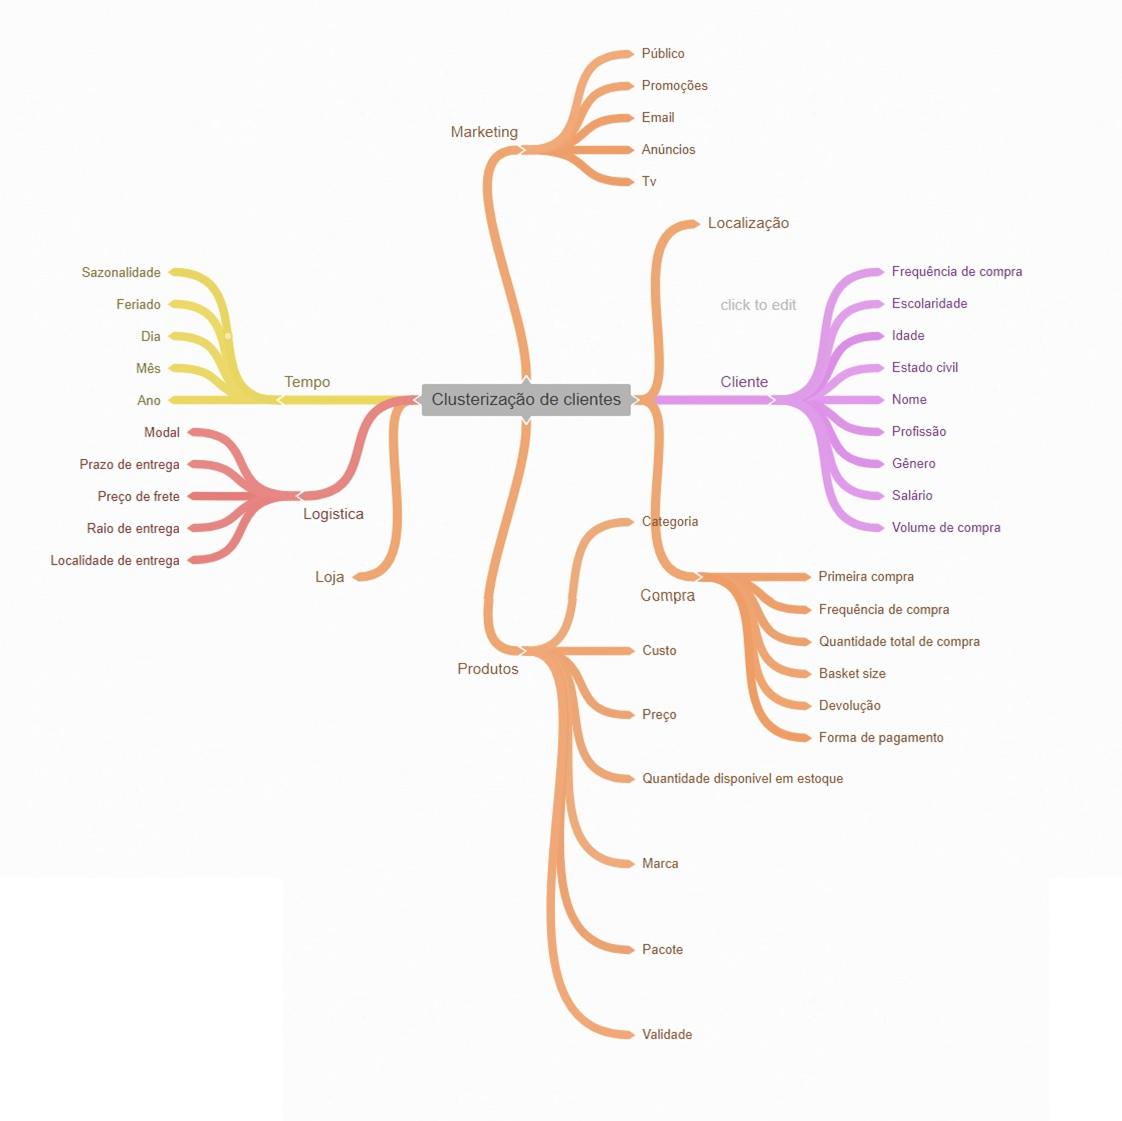

In [145]:
imagem_caminho = '../img/mapa_mental.jpg'

# Ajuste de tamanho (substitua os valores conforme necessário)
#largura = 990
#altura = 50

# Exibir a imagem
display(Image(filename = imagem_caminho))#, width = largura, height = altura))

### 10.2 Criação de hipóteses

### Afirmação do cluster tendo como base 'chute'

##### Hipótese Compra
**1.** Os clientes do cluster Insider usam cartão de crédito em 80% das compras?.

**2.** Os clientes do cluster Insider possuem um ticket média de 10% acima do cluster More products?.

**3.** Os clientes do cluster Insider possuem um basket size acima de 5 produtos?.

**4.** Os clientes do cluster Insider possuem um volume (produto) de compras acima de 10% do total de compras?.

**5.** Os clientes do cluster Insider possuem um volume (faturamento) de compras acima de 10% do total de compras?.

**6.** Os clientes do cluster Insider tem um número médio de devoluções abaixo da média da base total de clientes?.

##### Hipótese Cliente
**1.** 60% dos clientes do cluster Insider possuem o estado civil solterio?.

**2.** 10% dos clientes do cluster Insider estão na faixa etária de 24 à 35 anos?.

**3.** 40% das localidades de entrega do clientes do cluster Insider estão dentro de um raio de 50km?.

**4.** 5% dos clientes do cluster Insider recebem mais de 100 mil dólares anualmente?.

**5.** 5% dos clientes do cluster Insider tem ensino superior completo?.

##### Hipótese Produto
**1.** 30% de todos os produtos em pacotes grandes são comprados pelos clientes do cluster Insider?.

**2.** A mediana do faturamento dos clientes do cluster Insider é 10% maior do que a mediana do faturamento geral?.

**3.** O faturamento dos clientes do cluster Insider está concentrado no 3º quartil?.

**4.** O peso médio dos produtos comprados pelos clientes do cluster Insider é maior do que o peso médio dos outros clusters?.

**5.** A idade média dos produtos comprados pelos clientes do cluster Insider é menor do que 15 dias?.

### 10.3 Priorizar as hipóteses

**1.** Os clientes do cluster Insider possuem um volume (produto) de compras acima de 10% do total de compras?.

**2.** Os clientes do cluster Insider possuem um volume (faturamento) de compras acima de 10% do total de compra?.

**3.** Os clientes do cluster Insider tem um número médio de devoluções abaixo da média da base total de clientes?.

**4.** A mediana do faturamento dos clientes do cluster Insider é 10% maior do que a mediana do faturamento geral?.

**5.** O faturamento dos clientes do cluster Insider está concentrado no 3º quartil?.

### 10.4 Validação das hipóteses

**1.** Os clientes do cluster Insider possuem um volume (produto) de compras acima de 10% do total de compras?.

**Verdadeira** Os clientes do cluster Insider possuem um volume (produto) de compras acima de 54% do total de compras.

In [146]:
qtde_insiders = df10.loc[df10['cluster'] == 1, 'qty_products'].sum()
qtde_total = df10.loc[:, 'qty_products'].sum()  
print('Porcentagem (produtos) do cluster Insiders: {:.2f}%'.format(100 * qtde_insiders / qtde_total))

Porcentagem (produtos) do cluster Insiders: 54.48%


**2.** Os clientes do cluster Insider possuem um volume (faturamento) de compras acima de 10% do total de compra?.

**Verdadeira** Os clientes do cluster Insider possuem um volume (faturamento) de compras acima de 51% do total de compras.

In [147]:
qtde_insiders = df10.loc[df10['cluster'] == 1, 'gross_revenue'].sum()
qtde_total = df10.loc[:, 'gross_revenue'].sum()  
print('Porcentagem (faturamento) do cluster Insiders: {:.2f}%'.format(100 * qtde_insiders / qtde_total))

Porcentagem (faturamento) do cluster Insiders: 51.73%


**3.** Os clientes do cluster Insider tem um número médio de devoluções abaixo da média da base total de clientes?.

**Falso** A média de devoluções do cluster Insider tem um número médio de devoluções acima da média da base total de clientes.

In [148]:
qtde_insiders = df10.loc[df10['cluster'] == 1, 'qty_returns'].mean()
qtde_total = df10.loc[:, 'qty_returns'].mean()  
print('A média de returns do cluster Insiders: {:.2f} vs. o total de returns de toda a base: {:.2f}'.format(qtde_insiders, qtde_total))

A média de returns do cluster Insiders: 149.27 vs. o total de returns de toda a base: 34.89


**4.** A mediana do faturamento dos clientes do cluster Insider é 10% maior do que a mediana do faturamento geral?.

**Verdadeira** A mediana do faturamento dos clientes do cluster Insider é 2,7 vezes maior que a mediana do faturamento geral.

In [149]:
qtde_insiders = df10.loc[df10['cluster'] == 1, 'gross_revenue'].median()
qtde_total = df10.loc[:, 'gross_revenue'].median()
print('A mediana do cluster Insiders é: {:.2f}%'.format(100 * (qtde_insiders - qtde_total) / qtde_total))

A mediana do cluster Insiders é: 276.22%


**5.** O faturamento dos clientes do cluster Insider está concentrado no 3º quartil?.

**Falso** O faturamento dos clientes do cluster Insider está concentrado no 1º quartil.

In [150]:
np.percentile(df10.loc[df10['cluster'] == 1, 'gross_revenue'], q = 0.1)

617.56155

### 10.5 Relatório com as respostas das perguntas de negócio
    1. Quem são as pessoas elegíveis para participar do programa de Insiders?
    2. Quantos clientes farão parte do grupo?
    3. Quais as principais caracteristicas desses clientes?
    4. Qual a porcentagem de contribuição do faturameto vinda do Insiders?
    5. Qual a expectativa de faturamento desse grupo para os próximos meses?
    6. Quais as condições para uma pessoa ser elegível ao Insiders?
    7. Quais as condições para uma pessoa ser removida do Insiders?
    8. Qual a garantia que o programa Insiders é melhor que o restante da base?
    9. Quais ações o time de marketing pode realizar para aumentar o faturamento?  

**1.** Quem são as pessoas elegíveis para participar do programa de Insiders?

In [151]:
pd.DataFrame(df10.loc[df10['cluster'] == 1, 'customer_id']).head()

,customer_id
0,17850
2,12583
6,14688
8,15311
12,16029


**2.** Quantos clientes farão parte do grupo?

In [152]:
pd.DataFrame(df10.loc[df10['cluster'] == 1, 'customer_id']).size

468

**3.** Quais as principais caracteristicas desses clientes?

- Número de clientes: 468 (15,8% da base)
- Receita média: 8.835,89
- Recência em média: 21,4 dias
- Média de produtos comprados: 424 produtos
- Frequência de produtos comprados por dia: 0,09

**4.** Qual a porcentagem de contribuição do faturameto vinda do Insiders?

In [153]:
qtde_insiders = df10.loc[df10['cluster'] == 1, 'gross_revenue'].sum()
qtde_total = df10.loc[:, 'gross_revenue'].sum()  
print('Porcentagem (faturamento) do cluster Insiders: {:.2f}%'.format(100 * qtde_insiders / qtde_total))

Porcentagem (faturamento) do cluster Insiders: 51.73%


**5.** <s>Qual a expectativa de faturamento desse grupo para os próximos meses?</s>

**6.** Quais as condições para uma pessoa ser elegível ao Insiders?

**7.** Quais as condições para uma pessoa ser removida do Insiders?

**8.** Qual a garantia que o programa Insiders é melhor que o restante da base?

**9.** Quais ações o time de marketing pode realizar para aumentar o faturamento?  

# 11. (Modelo em produção) Passo 10: Modelo em produção

### 11.1 Salvar o modelo treinado de Ml

### 11.2 Classe do projeto (salvar em arquivo.py)

### 11.3 Criar API Handler (salvar em arquivo.py)

### 11.4 Testando a API